# Demand Forecasting - Time Series Analysis

## Introduction

In this notebook, we develop a comprehensive **time series forecasting** pipeline to predict store-item sales demand.

The workflow includes:
- **Exploratory Data Analysis (EDA):** Initial analysis of sales patterns across stores and items.
- **Feature Engineering:** Creating time-based features, rolling statistics, lag features, similarity-based clusters, exponentially weighted means, and statistical test-based groupings to extract useful signals.
- **Modeling:** Training and tuning **LightGBM Regressor** models with **SMAPE** as the evaluation metric, leveraging time series cross-validation.
- **Feature Importance:** Identifying key drivers behind the sales predictions.
- **Error Analysis:** In-depth residual analysis to detect potential modeling issues.
- **Visualization:** Plotting actual vs predicted sales, including normalized average sales trends.

This notebook demonstrates an **end-to-end pipeline** combining classical statistical approaches and machine learning for **time series forecasting**.

> Objective: Build a robust model to predict future sales as accurately as possible using advanced feature engineering and LightGBM.

## Data Summary

In this part, we start by loading the dataset and checking the basic summary.

- Summary:
  - Columns in the dataset.
  - Shape (rows and columns).
  - Number of unique stores and items.
  - Date range of the dataset.
  - Number of items per store.

This step helps us to understand the data before moving to modeling.

In [1]:
import warnings
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error

import lightgbm as lgb
import shap

import scipy.stats as stats
import itertools
import statsmodels.api as sm
from scipy.stats import zscore, shapiro, levene, ttest_ind, mannwhitneyu

df = pd.read_csv("train.csv", low_memory=False)
train = df.copy()
print("**** SUMMARY ****")
print("Columns: ",df.columns)
print("Shape of dataframe: ",df.shape)
print("Unique store numbers:", train.store.nunique(),"\nUnique item numbers:", train.item.nunique())
print("Date interval: ", "from", train["date"].min(),"to", train["date"].max())
print("\nItems by store:")

**** SUMMARY ****
Columns:  Index(['date', 'store', 'item', 'sales'], dtype='object')
Shape of dataframe:  (913000, 4)
Unique store numbers: 10 
Unique item numbers: 50
Date interval:  from 2013-01-01 to 2017-12-31

Items by store:


## Sales Statistics by Item

In this step, we calculate summary statistics for each item.

- We group the data by item.
- We calculate:
  - Total number of records.
  - Total sales.
  - Mean sales.
  - Median sales.
  - Standard deviation of sales.
  - Minimum sales.
  - Maximum sales.

This helps to understand the sales patterns of each item.

In [2]:
df.groupby(["item"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

sales                                               
      count      sum       mean median        std min  max
item                                                      
1     18260   401384  21.981599   21.0   8.468922   1   59
2     18260  1069564  58.574151   56.0  20.093015   9  150
3     18260   669087  36.642223   35.0  13.179441   7  104
4     18260   401907  22.010241   21.0   8.403898   0   66
5     18260   335230  18.358708   18.0   7.265167   1   50
6     18260  1068281  58.503888   56.0  20.174898  11  148
7     18260  1068777  58.531051   56.0  20.146002  11  141
8     18260  1405108  76.950055   74.0  26.130697  15  181
9     18260   938379  51.389869   49.5  17.790158   6  134
10    18260  1337133  73.227437   70.0  24.823725  14  175
11    18260  1271925  69.656353   67.0  23.744732  11  170
12    18260  1271534  69.634940   67.0  23.738663  12  170
13    18260  1539621  84.316594   81.0  28.311031  20  210
14    18260  1071531  58.681873   56.0  20.079860  12  152
15    18260  1607442  88.030778   85.0  29.522852  17  231
16    18260   468480  25.656079   25.0   9.603270   2   70
17    18260   602486  32.994852   32.0  11.967610   4   83
18    18260  1538876  84.275794   81.0  28.430621  18  208
19    18260   736892  40.355531   39.0  14.332645   5   99
20    18260   867641  47.515936   46.0  16.490487   9  127
21    18260   736190  40.317087   39.0  14.338006   7  109
22    18260  1469971  80.502245   78.0  27.118163  14  214
23    18260   534979  29.297864   28.0  10.819549   3   81
24    18260  1205975  66.044633   64.0  22.531555  14  156
25    18260  1473334  80.686418   78.0  27.238817  18  193
26    18260   869981  47.644085   46.0  16.723912   8  119
27    18260   402628  22.049726   21.0   8.461641   1   59
28    18260  1604713  87.881325   85.0  29.501781  16  206
29    18260  1271240  69.618839   67.0  23.635631  15  173
30    18260   736554  40.337021   39.0  14.363331   5  115
31    18260  1070845  58.644304   57.0  20.104705  10  159
32    18260   803107  43.981763   42.0  15.574556   5  119
33    18260  1270183  69.560953   67.0  23.718343  15  169
34    18260   469935  25.735761   25.0   9.617910   2   79
35    18260  1201541  65.801807   63.0  22.461990  12  168
36    18260  1406548  77.028916   74.0  26.067440  16  188
37    18260   534258  29.258379   28.0  10.771547   3   74
38    18260  1470330  80.521906   77.0  27.141799  15  188
39    18260   801311  43.883406   42.0  15.511550   7  112
40    18260   534094  29.249398   28.0  10.822959   3   74
41    18260   401759  22.002136   21.0   8.402470   2   60
42    18260   669925  36.688116   35.0  13.215112   5   96
43    18260   936635  51.294359   49.0  17.801008   9  126
44    18260   536811  29.398193   28.0  10.797738   3   78
45    18260  1471467  80.584173   78.0  27.318402  18  205
46    18260  1070764  58.639869   56.0  20.220879  11  150
47    18260   401781  22.003341   21.0   8.420102   2   61
48    18260   937703  51.352848   49.0  17.881917   8  130
49    18260   535663  29.335323   28.0  10.874788   3   77
50    18260  1203009  65.882202   63.0  22.416031  12  164

## Sales Distribution by Store

Here, we visualize the sales distribution for each store.

- We plot histograms for each store separately.
- The x-axis shows the sales amount.
- The y-axis shows the number of records.
- This helps to compare the sales patterns between stores.

As a result:
- Most stores have a similar pattern.
- Sales distributions are right-skewed, meaning low sales are more common, while high sales are rare.

This step gives a clear overview of **how sales are distributed across stores**.

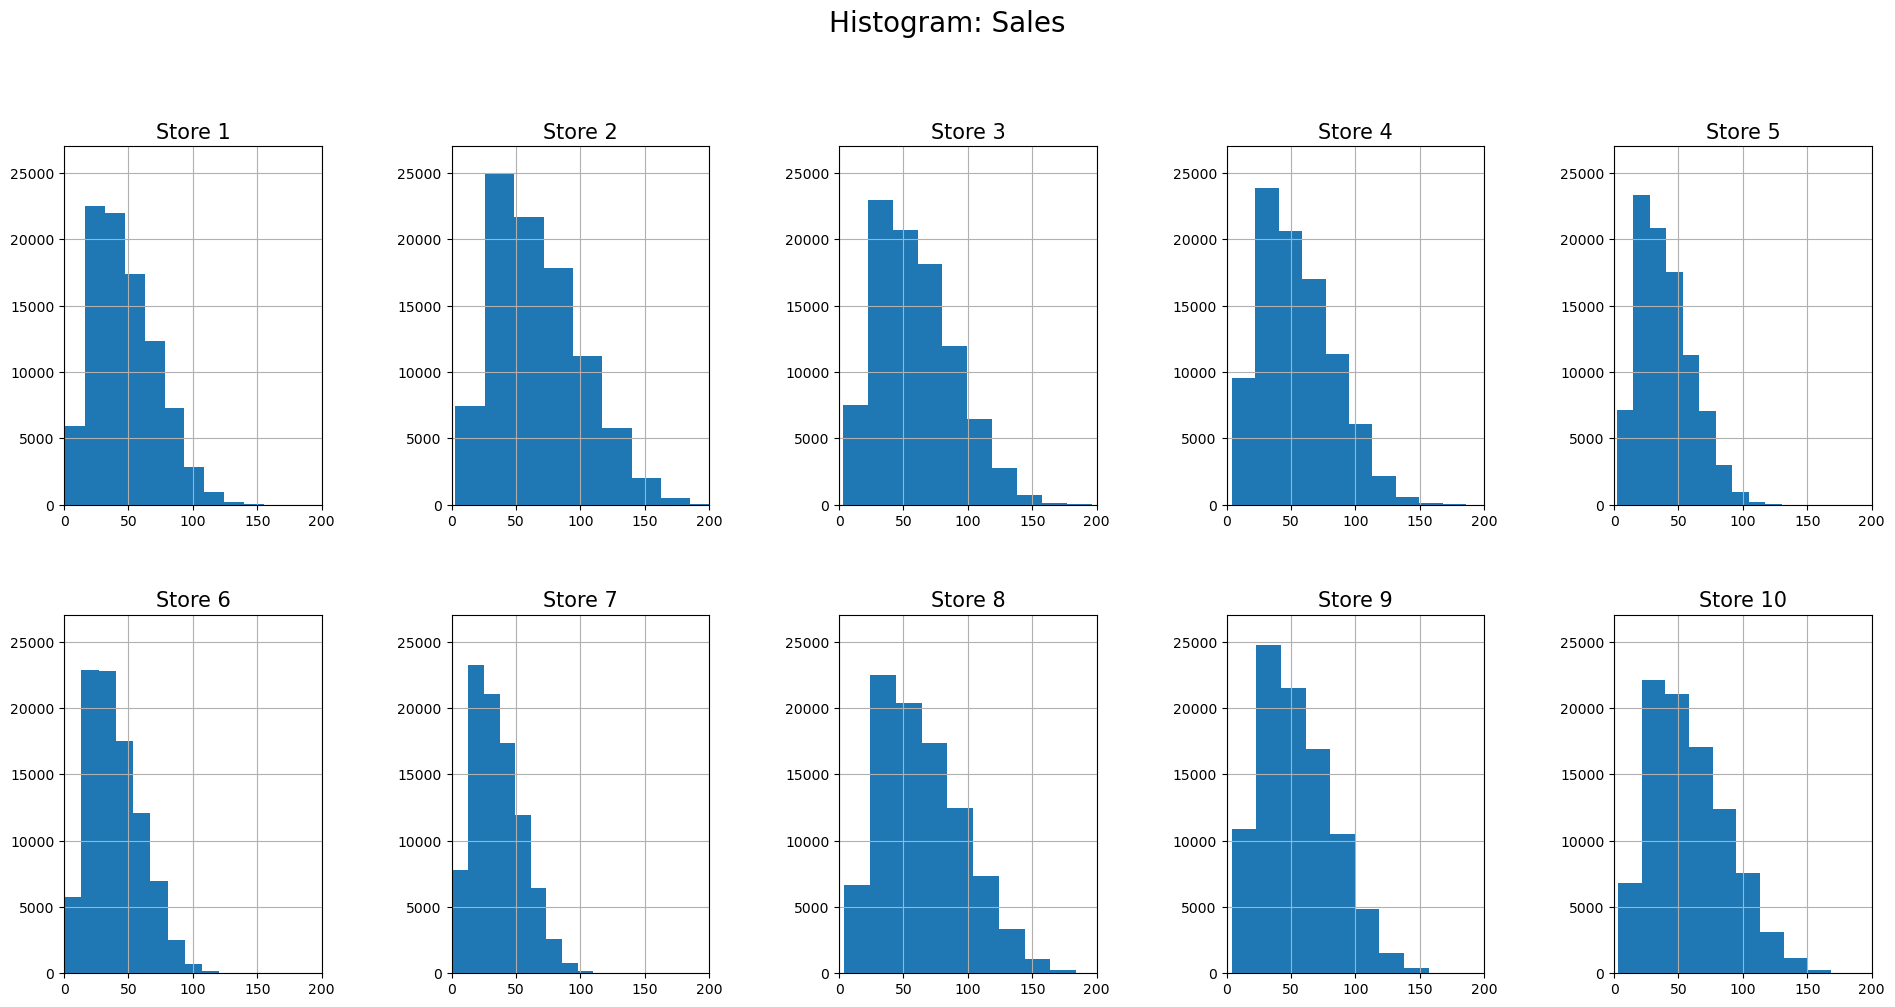

In [3]:
bins = 10
max_y = 27000

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i in range(1, 11):
    ax = axes[0, i - 1] if i < 6 else axes[1, i - 6]
    train[train.store == i].sales.hist(ax=ax, bins=bins)
    ax.set_title("Store " + str(i), fontsize=15)
    ax.set_xlim(0, 200)
    ax.set_ylim(0, max_y)
plt.tight_layout(pad=4.5)
plt.suptitle("Histogram: Sales", fontsize=20, y=1.05)
plt.show()

## Sales Distribution by Item (Store 1)

Here, we analyze the sales patterns of individual items within **Store 1**.

- We create line plots for each of the 50 items.
- The x-axis shows the time points (daily records).
- The y-axis shows the sales quantity.
- Each plot displays the actual sales trend of one item.

As a result:
- Most items show clear **seasonal patterns** and **weekly cycles**.
- Some items have more stable sales, while others fluctuate more.
- This helps to identify items with similar or different behaviors.

This step provides a detailed look at **how item sales change over time** inside the store.

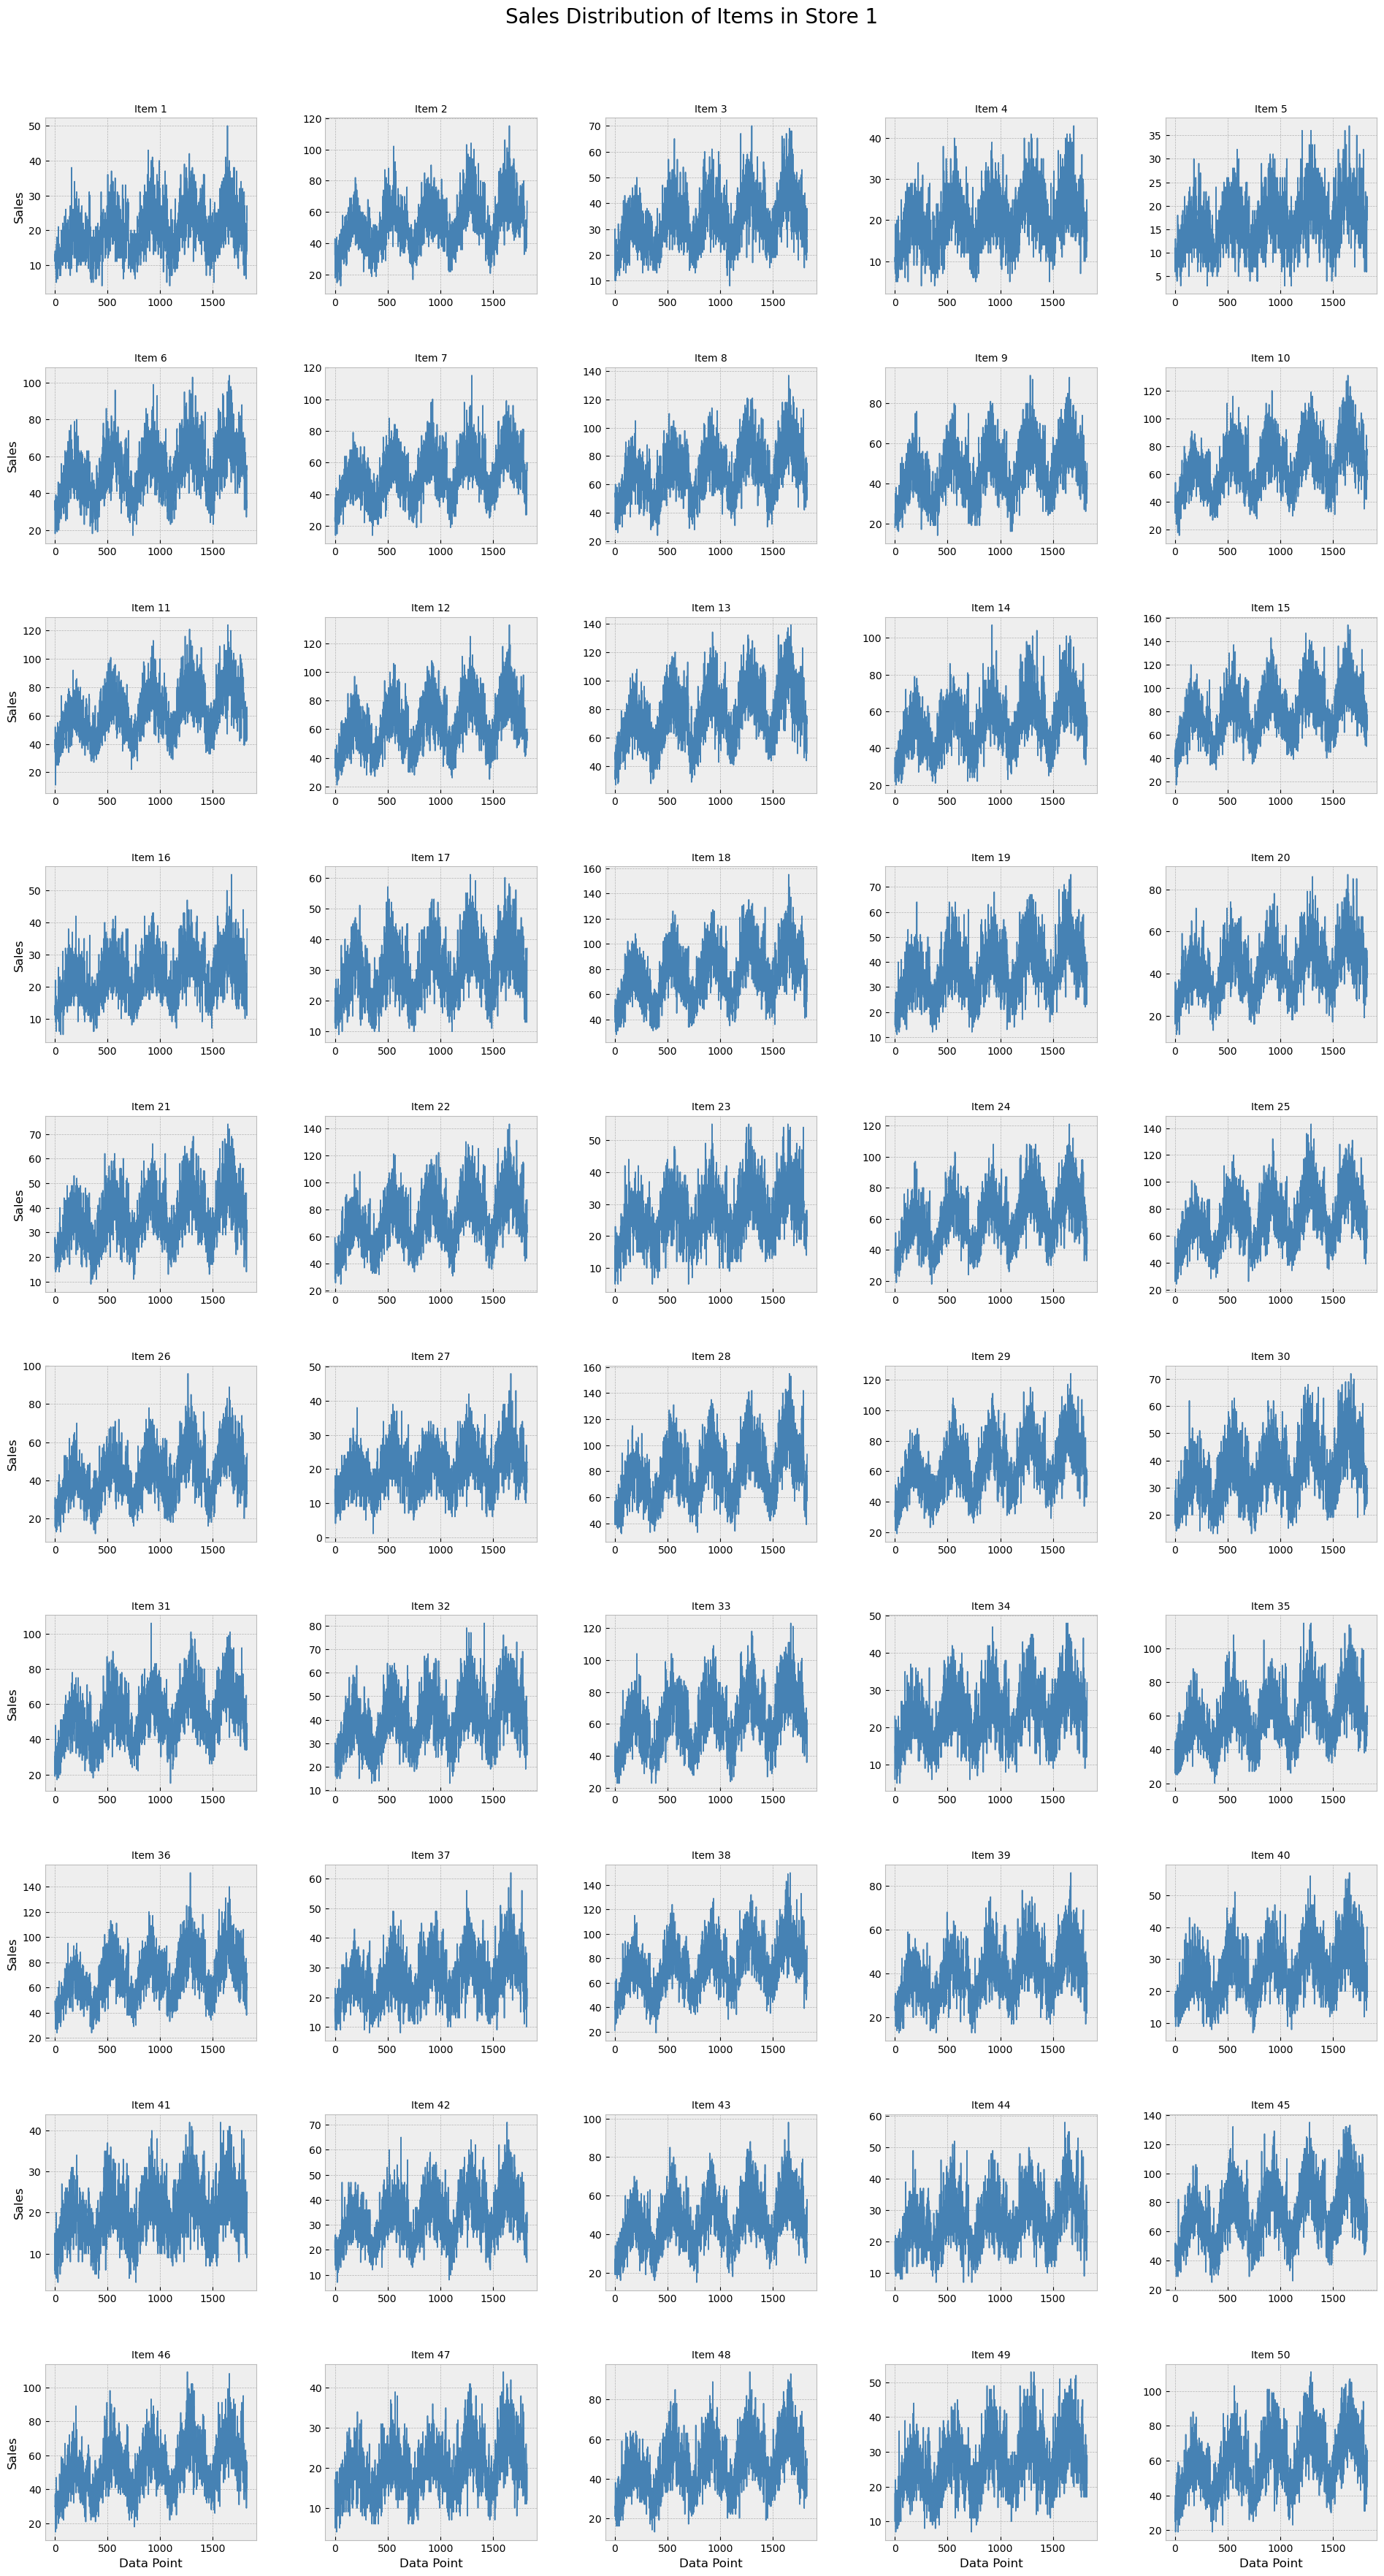

In [4]:
plt.style.use("bmh")

store = 1
sub = train[train.store == store]

fig, axes = plt.subplots(10, 5, figsize=(20, 35))

for i in range(1, 51):
    row = (i - 1) // 5
    col = (i - 1) % 5
    sales_series = sub[sub.item == i].sales.reset_index(drop=True)
    sales_series.plot(ax=axes[row, col], linewidth=1.2, color="steelblue")
    axes[row, col].set_title(f"Item {i}", fontsize=10)
    
    if row == 9:
        axes[row, col].set_xlabel("Data Point")
    else:
        axes[row, col].set_xlabel("")
    
    if col == 0:
        axes[row, col].set_ylabel("Sales")
    else:
        axes[row, col].set_ylabel("")

plt.tight_layout(pad=4.5)
plt.suptitle("Sales Distribution of Items in Store 1", fontsize=20, y=1.02)
plt.show()

## Normalized Sales Trend (Smoothed)

In this step, we analyze the sales trends of all items in **Store 1** using a smoother and cleaner line plot.

### What we did:
- Sales of each item are **normalized** to a scale of 0 to 1.
- We apply a **rolling average (window=30)** to reduce the noise and highlight the overall trend.
- No legends are shown here to avoid clutter.

### Why we did this:
- Normalization removes the scale difference between items.
- Smoothing makes the trends easier to see.
- This plot focuses on the **seasonal patterns and overall fluctuations** of sales.

This approach provides a simple yet effective way to compare sales behaviors of different items over time.

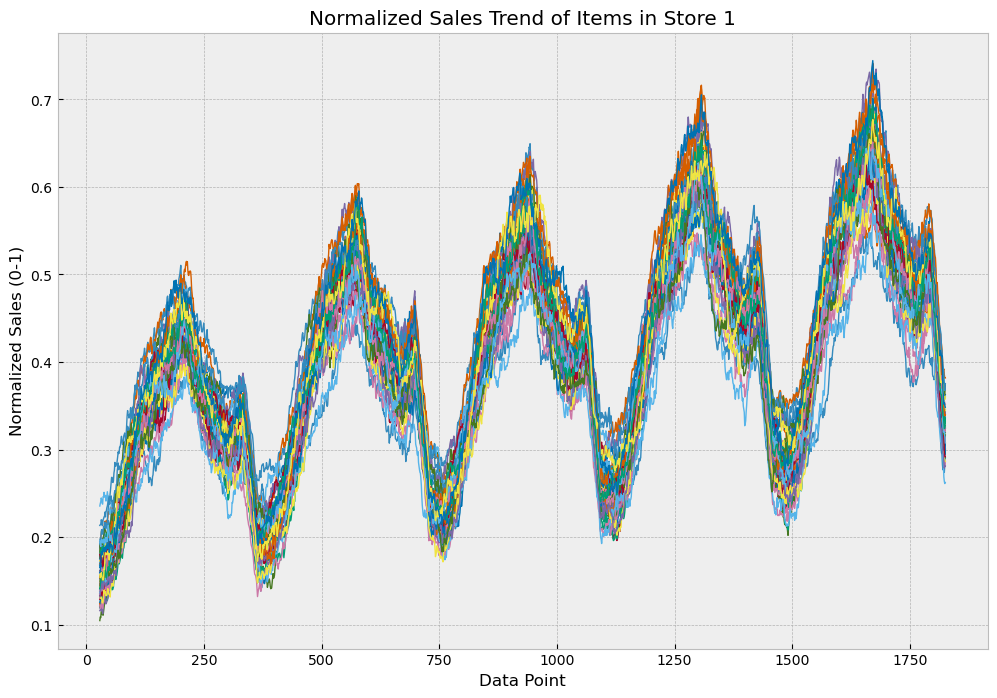

In [5]:
plt.figure(figsize=(12, 8))

for i in range(1, 51):
    sales_series = sub[sub.item == i].sales.reset_index(drop=True)
    normalized_series = (sales_series - sales_series.min()) / (sales_series.max() - sales_series.min())
    plt.plot(normalized_series.rolling(window=30).mean(), linewidth=1, label=f'Item {i}')

plt.title("Normalized Sales Trend of Items in Store 1")
plt.xlabel("Data Point")
plt.ylabel("Normalized Sales (0-1)")
plt.show()

## Store Sales Correlation (Spearman)

In this step, we analyze the relationship between stores by calculating the **Spearman correlation** of their total daily sales.

### What we did:
- Aggregated daily total sales for each store.
- Computed **Spearman correlation** between stores.
- Visualized the results using a **heatmap**:
  - Only correlations above **0.5** or below **-0.5** are displayed.
  - The heatmap is masked to show only the lower triangle for clarity.
  - Colors range from blue (low correlation) to red (high correlation).

### Key Insights:
- Many stores show **strong positive correlations** with each other.
- This suggests that **similar sales patterns** exist between stores.
- These correlations may reflect shared seasonality or similar customer behaviors.

This analysis helps to understand **how closely the stores follow similar sales trends**.

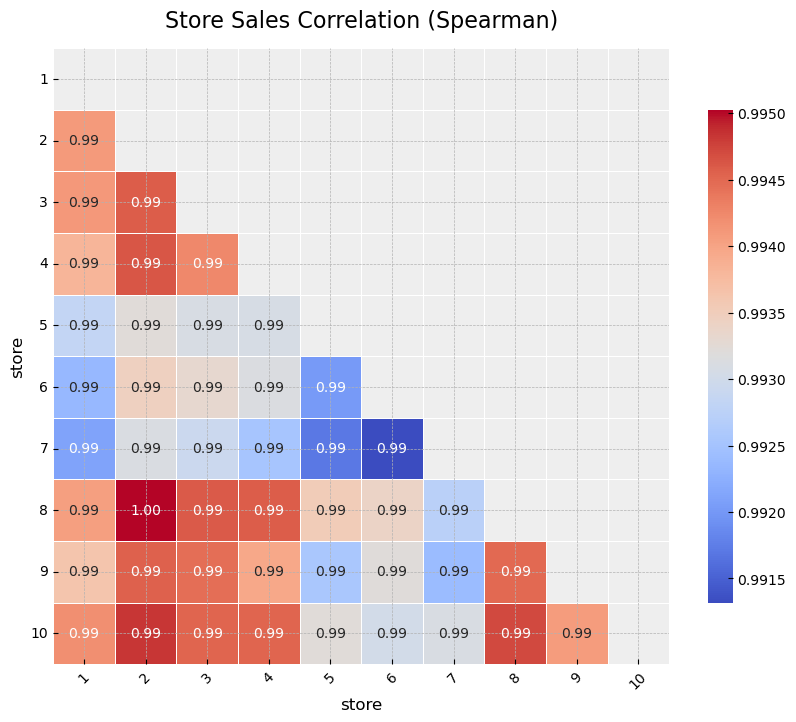

In [6]:
storesales = train.groupby(["date", "store"]).sales.sum().reset_index().set_index("date")
corr = pd.pivot_table(storesales, values="sales", columns="store", index="date").corr(method="spearman")

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr[(corr >= 0.5) | (corr <= -0.5)],
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    square=True
)
plt.title("Store Sales Correlation (Spearman)", fontsize=16, pad=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

## Hypothesis Testing Between Stores

In this step, we compare sales distributions between different stores using statistical hypothesis testing.

### What we did:
- For each pair of stores:
  - We first checked the **normality** of their sales data.
  - Then, we selected the right test automatically:
    - If both groups are normal → Parametric test (T-test).
    - If at least one group is not normal → Non-parametric test (Mann-Whitney U test).
- We identified whether the groups are **statistically different** or **similar**.

### Output:
- Each row shows a comparison between two stores.
- Key columns:
  - `TestType`: Type of test used (Parametric or Non-Parametric).
  - `Compare Two Groups`: Are the groups similar or different?
  - `p-value`: Test result significance.
  - Group medians and means for more context.

### Key Insight:
- Most store pairs are marked as **"Different Groups"**.
- This means stores generally have **distinct sales distributions**.
- Such grouping can later help in clustering or segmentation tasks.

This analysis is crucial for **understanding structural differences between stores** before modeling.

In [7]:
def CompareTwoGroups(dataframe, group, target):
    
    item_comb = list(itertools.combinations(dataframe[group].unique(), 2))
    
    AB = pd.DataFrame()
    for i in range(len(item_comb)):
        groupA = dataframe[dataframe[group] == item_comb[i][0]][target]
        groupB = dataframe[dataframe[group] == item_comb[i][1]][target]
        
        ntA = shapiro(groupA)[1] < 0.05
        ntB = shapiro(groupB)[1] < 0.05
        
        if not ntA and not ntB:
            leveneTest = stats.levene(groupA, groupB)[1] < 0.05
            if not leveneTest:
                ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            else:
                ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
        else:
            ttest = stats.mannwhitneyu(groupA, groupB)[1]

        temp = pd.DataFrame({
            "Compare Two Groups": [ttest < 0.05],
            "p-value": [ttest],
            "GroupA_Mean": [groupA.mean()],
            "GroupB_Mean": [groupB.mean()],
            "GroupA_Median": [groupA.median()],
            "GroupB_Median": [groupB.median()],
            "GroupA_Count": [groupA.count()],
            "GroupB_Count": [groupB.count()]
        }, index=[item_comb[i]])

        temp["Compare Two Groups"] = np.where(temp["Compare Two Groups"], "Different Groups", "Similar Groups")
        temp["TestType"] = np.where((not ntA) and (not ntB), "Parametric", "Non-Parametric")
        
        AB = pd.concat([AB, temp[[
            "TestType", "Compare Two Groups", "p-value",
            "GroupA_Median", "GroupB_Median", "GroupA_Mean", "GroupB_Mean",
            "GroupA_Count", "GroupB_Count"
        ]]])
        
    return AB

CompareTwoGroups(storesales, group="store", target="sales")

TestType Compare Two Groups        p-value  GroupA_Median  \
(1, 2)   Non-Parametric   Different Groups  1.142171e-261         2339.5   
(1, 3)   Non-Parametric   Different Groups  9.986606e-135         2339.5   
(1, 4)   Non-Parametric   Different Groups   4.089808e-62         2339.5   
(1, 5)   Non-Parametric   Different Groups   1.482497e-80         2339.5   
(1, 6)   Non-Parametric   Different Groups   1.322467e-81         2339.5   
(1, 7)   Non-Parametric   Different Groups  4.984442e-167         2339.5   
(1, 8)   Non-Parametric   Different Groups  2.806842e-213         2339.5   
(1, 9)   Non-Parametric   Different Groups   6.988553e-64         2339.5   
(1, 10)  Non-Parametric   Different Groups  7.007060e-121         2339.5   
(2, 3)   Non-Parametric   Different Groups   1.634782e-40         3310.5   
(2, 4)   Non-Parametric   Different Groups  5.315817e-105         3310.5   
(2, 5)   Non-Parametric   Different Groups   0.000000e+00         3310.5   
(2, 6)   Non-Parametric   Different Groups   0.000000e+00         3310.5   
(2, 7)   Non-Parametric   Different Groups   0.000000e+00         3310.5   
(2, 8)   Non-Parametric   Different Groups   4.617581e-07         3310.5   
(2, 9)   Non-Parametric   Different Groups  3.020917e-102         3310.5   
(2, 10)  Non-Parametric   Different Groups   8.723864e-50         3310.5   
(3, 4)   Non-Parametric   Different Groups   2.922555e-20         2937.5   
(3, 5)   Non-Parametric   Different Groups   0.000000e+00         2937.5   
(3, 6)   Non-Parametric   Different Groups   0.000000e+00         2937.5   
(3, 7)   Non-Parametric   Different Groups   0.000000e+00         2937.5   
(3, 8)   Non-Parametric   Different Groups   2.109291e-17         2937.5   
(3, 9)   Non-Parametric   Different Groups   5.640845e-19         2937.5   
(3, 10)  Non-Parametric     Similar Groups   1.066245e-01         2937.5   
(4, 5)   Non-Parametric   Different Groups  5.267191e-232         2708.0   
(4, 6)   Non-Parametric   Different Groups  1.822562e-233         2708.0   
(4, 7)   Non-Parametric   Different Groups   0.000000e+00         2708.0   
(4, 8)   Non-Parametric   Different Groups   7.821879e-67         2708.0   
(4, 9)   Non-Parametric     Similar Groups   7.654646e-01         2708.0   
(4, 10)  Non-Parametric   Different Groups   1.959591e-14         2708.0   
(5, 6)   Non-Parametric     Similar Groups   9.039760e-01         1970.5   
(5, 7)   Non-Parametric   Different Groups   3.383446e-24         1970.5   
(5, 8)   Non-Parametric   Different Groups   0.000000e+00         1970.5   
(5, 9)   Non-Parametric   Different Groups  6.164859e-234         1970.5   
(5, 10)  Non-Parametric   Different Groups  3.131785e-304         1970.5   
(6, 7)   Non-Parametric   Different Groups   8.372915e-24         1963.0   
(6, 8)   Non-Parametric   Different Groups   0.000000e+00         1963.0   
(6, 9)   Non-Parametric   Different Groups  2.851016e-235         1963.0   
(6, 10)  Non-Parametric   Different Groups  1.110687e-305         1963.0   
(7, 8)   Non-Parametric   Different Groups   0.000000e+00         1796.5   
(7, 9)   Non-Parametric   Different Groups   0.000000e+00         1796.5   
(7, 10)  Non-Parametric   Different Groups   0.000000e+00         1796.5   
(8, 9)   Non-Parametric   Different Groups   1.266282e-64         3174.5   
(8, 10)  Non-Parametric   Different Groups   1.146573e-23         3174.5   
(9, 10)  Non-Parametric   Different Groups   2.118494e-13         2719.5   

         GroupB_Median  GroupA_Mean  GroupB_Mean  GroupA_Count  GroupB_Count  
(1, 2)          3310.5  2363.418949  3351.658269          1826          1826  
(1, 3)          2937.5  2363.418949  2976.530120          1826          1826  
(1, 4)          2708.0  2363.418949  2745.147317          1826          1826  
(1, 5)          1970.5  2363.418949  1988.508215          1826          1826  
(1, 6)          1963.0  2363.418949  1986.675794          1826          1826  
(1, 7)          1796.5  2363.418949  1818.18

## Hypothesis Testing Between Items

In this step, we apply the same hypothesis testing process, but this time for **items** instead of stores.

### What we did:
- For each pair of items:
  - We tested if their sales distributions are statistically similar or different.
  - Non-parametric tests were used in most cases.

### Output:
- The table shows only the item pairs with **"Similar Groups"**.
- Key columns:
  - `TestType`: Type of test used.
  - `Compare Two Groups`: Similar or different groups.
  - `p-value`: Test significance.
  - Group medians and means for additional insight.

### Key Insight:
- Several items have **very similar sales patterns**.
- These items can later be grouped together to simplify modeling or feature engineering.

In [8]:
itemsales = train.groupby(["date", "item"]).sales.sum().reset_index().set_index("date")
ctg_is = CompareTwoGroups(itemsales, group = "item", target = "sales")

pd.set_option("display.max_rows", None)  # Tüm satırları göstermek için

ctg_is[ctg_is["Compare Two Groups"] == "Similar Groups"]

TestType Compare Two Groups   p-value  GroupA_Median  \
(1, 4)    Non-Parametric     Similar Groups  0.842383          218.0   
(1, 27)   Non-Parametric     Similar Groups  0.746252          218.0   
(1, 41)   Non-Parametric     Similar Groups  0.961622          218.0   
(1, 47)   Non-Parametric     Similar Groups  0.946145          218.0   
(2, 6)    Non-Parametric     Similar Groups  0.899452          578.0   
(2, 7)    Non-Parametric     Similar Groups  0.976249          578.0   
(2, 14)   Non-Parametric     Similar Groups  0.817509          578.0   
(2, 31)   Non-Parametric     Similar Groups  0.823525          578.0   
(2, 46)   Non-Parametric     Similar Groups  0.922785          578.0   
(3, 42)   Non-Parametric     Similar Groups  0.832318          362.5   
(4, 27)   Non-Parametric     Similar Groups  0.891394          218.0   
(4, 41)   Non-Parametric     Similar Groups  0.901862          218.0   
(4, 47)   Non-Parametric     Similar Groups  0.902856          218.0   
(6, 7)    Non-Parametric     Similar Groups  0.924904          578.5   
(6, 14)   Non-Parametric     Similar Groups  0.726355          578.5   
(6, 31)   Non-Parametric     Similar Groups  0.752276          578.5   
(6, 46)   Non-Parametric     Similar Groups  0.829613          578.5   
(7, 14)   Non-Parametric     Similar Groups  0.801538          580.0   
(7, 31)   Non-Parametric     Similar Groups  0.811905          580.0   
(7, 46)   Non-Parametric     Similar Groups  0.901850          580.0   
(8, 36)   Non-Parametric     Similar Groups  0.901155          759.0   
(9, 43)   Non-Parametric     Similar Groups  0.806626          511.0   
(9, 48)   Non-Parametric     Similar Groups  0.903478          511.0   
(11, 12)  Non-Parametric     Similar Groups  0.992900          690.0   
(11, 29)  Non-Parametric     Similar Groups  0.979504          690.0   
(11, 33)  Non-Parametric     Similar Groups  0.873795          690.0   
(12, 29)  Non-Parametric     Similar Groups  0.985112          691.5   
(12, 33)  Non-Parametric     Similar Groups  0.878385          691.5   
(13, 18)  Non-Parametric     Similar Groups  0.941612          833.0   
(14, 31)  Non-Parametric     Similar Groups  0.984461          579.0   
(14, 46)  Non-Parametric     Similar Groups  0.899142          579.0   
(15, 28)  Non-Parametric     Similar Groups  0.848848          868.0   
(16, 34)  Non-Parametric     Similar Groups  0.752381          255.0   
(19, 21)  Non-Parametric     Similar Groups  0.897813          400.0   
(19, 30)  Non-Parametric     Similar Groups  0.973145          400.0   
(20, 26)  Non-Parametric     Similar Groups  0.797161          470.0   
(21, 30)  Non-Parametric     Similar Groups  0.930440          398.0   
(22, 25)  Non-Parametric     Similar Groups  0.845824          795.0   
(22, 38)  Non-Parametric     Similar Groups  0.994678          795.0   
(22, 45)  Non-Parametric     Similar Groups  0.968202          795.0   
(23, 37)  Non-Parametric     Similar Groups  0.764205          289.0   
(23, 40)  Non-Parametric     Similar Groups  0.777612          289.0   
(23, 44)  Non-Parametric     Similar Groups  0.681361          289.0   
(23, 49)  Non-Parametric     Similar Groups  0.987616          289.0   
(24, 35)  Non-Parametric     Similar Groups  0.650417          654.0   
(24, 50)  Non-Parametric     Similar Groups  0.803420          654.0   
(25, 38)  Non-Parametric     Similar Groups  0.838802          797.0   
(25, 45)  Non-Parametric     Similar Groups  0.881083          797.0   
(27, 41)  Non-Parametric     Similar Groups  0.781946          218.0   
(27, 47)  Non-Parametric     Similar Groups  0.788775          218.0   
(29, 33)  Non-Parametric     Similar Groups  0.868444          691.5   
(31, 46)  Non-Parametric     Similar Groups  0.912820          582.0   
(32, 39)  Non-Parametric     Similar Groups  0.794243          434.5   
(35, 50)  Non-Parametric     Similar Groups  0.826470          649.0   
(37, 40)  Non-Parametric     Similar Groups  0.993676   

## Feature Engineering: Creating Time-Based Features

In this section, we create many useful features to improve the sales forecasting model.

### 1. Calendar Features  
We extract time-based details from the `date` column:
- Month, day, day of year, week, weekday, year, quarter.
- Flags for special dates such as start or end of month, quarter, and year.
- Season indicator: winter, spring, summer, or fall.
- Weekend flag.

These features help the model understand **seasonality, holidays, and periodic effects**.


### 2. Lag Features (Past Sales)
We create **lag features** by shifting past sales values.
- Different lag periods are selected to capture both short-term and long-term effects.
- Lagged sales can help the model learn trends and autocorrelation patterns.

We also remove highly correlated lag features to prevent redundancy.

### 3. Rolling Mean Features
We calculate **rolling average sales** over various window sizes.
- This smooths out short-term fluctuations and shows general trends.
- Rolling means are shifted to avoid data leakage.


### 4. Exponentially Weighted Mean Features (EWM)
We generate features based on **exponential smoothing**:
- Recent sales are given more weight than older ones.
- Different smoothing levels (`alpha` values) are applied to capture various patterns.

### 5. Monthly Aggregated Features
We aggregate sales for the past months at different levels:
- Store & Item level.
- Store level.
- Item level.
- Similarity groups (based on hypothesis testing).

We compute **sum, mean, std, min, and max** values for each period.


### 6. Day of Week Lag Features
We create lag features specifically for each **day of the week**.
This allows the model to capture **weekly sales patterns** effectively.


### 7. Clustering-Based Features
Stores and items are grouped into clusters based on average sales.
- Store clusters (4 groups).
- Item clusters (5 groups).

These clusters help the model recognize sales behaviors of similar stores or products.


### Summary:
This feature engineering pipeline is designed to capture:
- Time patterns (seasonality, holidays).
- Autocorrelation (past sales effects).
- Weekly cycles.
- Similar store/item behaviors.

It creates a rich set of features for accurate and robust forecasting.

In [9]:
# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract time-based features from the date column
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.isocalendar().week
    df['day_of_week'] = df.date.dt.dayofweek + 1
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df["quarter"] = df.date.dt.quarter
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    df['is_quarter_start'] = df.date.dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.date.dt.is_quarter_end.astype(int)
    df['is_year_start'] = df.date.dt.is_year_start.astype(int)
    df['is_year_end'] = df.date.dt.is_year_end.astype(int)
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = np.where(df.month.isin([9, 10, 11]), 3, df["season"])
    return df
df = create_date_features(df)


# Generate rolling mean features for different window sizes
for i in [91, 98, 105, 112, 119, 126, 186, 200, 210, 250, 300, 365, 546, 700]:
    df["sales_roll_mean_"+str(i)]=df.groupby(["store", "item"]).sales.rolling(i).mean().shift(1).values

# Define store similarity groups based on hypothesis testing

# Store Based
storesales = train.groupby(["date", "store"]).sales.sum().reset_index()
ctg_ss = CompareTwoGroups(storesales, group="store", target="sales")
del storesales

df["StoreSalesSimilarity"] = np.where(df.store.isin([3,10]), 1, 0)
df["StoreSalesSimilarity"] = np.where(df.store.isin([4,9]), 2, df["StoreSalesSimilarity"])
df["StoreSalesSimilarity"] = np.where(df.store.isin([5,6]), 3, df["StoreSalesSimilarity"])

# Item Based

itemsales = train.groupby(["date", "item"]).sales.sum().reset_index()
ctg_is = CompareTwoGroups(itemsales, group = "item", target = "sales")
del itemsales

df["ItemSalesSimilarity"] = np.where(df.item.isin([1,4,27,41,47]), 1, 0)
df["ItemSalesSimilarity"] = np.where(df.item.isin([2,6,7,14,31,46]), 2, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([3,42]), 3, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([8,36]), 4, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([9,43,48]), 5, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([11,12,29,33]), 6, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([13,18]), 7, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([15,28]), 8, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([16,34]), 9, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([19,21,30]), 10, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([20,26]), 11, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([22,25,38,45]), 12, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([23,37,40,44,49]), 13, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([24,35,50]), 14, df["ItemSalesSimilarity"])
df["ItemSalesSimilarity"] = np.where(df.item.isin([32,39]), 15, df["ItemSalesSimilarity"])

# Generate lag features to capture past sales patterns
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)


# Drop highly correlated lag features
def lag_features(dataframe, lags, groups = ["store", "item"], target = "sales", prefix = ''):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe[prefix + str(lag)] = dataframe.groupby(groups)[target].transform(
            lambda x: x.shift(lag))
    return dataframe

df = lag_features(df, lags = [91, 92,93,94,95,96, 97, 98, 100, 105, 112, 119, 126, 150,
                              182,200,220, 250, 300, 350, 355, 360,361,362,363, 364,
                              365, 370, 375,380, 546, 600, 650, 680, 690, 700, 710, 728,
                              730, 800, 900, 950, 990, 1000, 1050, 1090, 1095],
                  groups = ["store", "item"], target = 'sales', prefix = 'sales_lag_')

def drop_cor(dataframe, name, index):
    ind = dataframe[dataframe.columns[dataframe.columns.str.contains(name)].tolist()+["sales"]].corr().sales.sort_values(ascending = False).index[1:index]
    ind = dataframe.drop(ind, axis = 1).columns[dataframe.drop(ind, axis = 1).columns.str.contains(name)]
    dataframe.drop(ind, axis = 1, inplace = True)

drop_cor(df, "sales_lag", 16)


# Generate monthly summary features for different groupings
df["monthyear"] = df.date.dt.to_period('M')

# Store-Item Based
for i in [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]:
    last_months = df.groupby(["store", "item", "monthyear"]).sales.agg([
        "sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['store', 'item', 'monthyear', 'last_'+str(i)+'months_sales_sum',
                           'last_'+str(i)+'months_sales_mean', 'last_'+str(i)+'months_sales_std',
                           'last_'+str(i)+'months_sales_min', 'last_'+str(i)+'months_sales_max']
    df = pd.merge(df, last_months, how   = "left", on = ["store", "item", "monthyear"])
del last_months, i

drop_cor(df, "last_", 15)

# Store Based
for i in [3, 6, 9, 12]:
    last_months = df.groupby(["store", "monthyear"]).sales.agg([
        "sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['store', 'monthyear', 'store_last_'+str(i)+'months_sales_sum',
                           'store_last_'+str(i)+'months_sales_mean', 'store_last_'+str(i)+'months_sales_std',
                           'store_last_'+str(i)+'months_sales_min', 'store_last_'+str(i)+'months_sales_max']
    df = pd.merge(df, last_months, how = "left", on = ["store", "monthyear"])
del last_months, i

# Item Based
for i in [3, 6, 9, 12]:
    last_months = df.groupby(["item", "monthyear"]).sales.agg([
        "sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['item', 'monthyear', 'item_last_'+str(i)+'months_sales_sum',
                           'item_last_'+str(i)+'months_sales_mean', 'item_last_'+str(i)+'months_sales_std',
                           'item_last_'+str(i)+'months_sales_min', 'item_last_'+str(i)+'months_sales_max']
    df = pd.merge(df, last_months, how = "left", on = ["item", "monthyear"])
del last_months, i

# Similarity Based
for i in [3, 6, 9, 12]:
    last_months = df.groupby(["StoreSalesSimilarity", "monthyear"]).sales.agg([
        "sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['StoreSalesSimilarity', 'monthyear', 'storesim_last_'+str(i)+'months_sales_sum',
                           'storesim_last_'+str(i)+'months_sales_mean', 'storesim_last_'+str(i)+'months_sales_std',
                           'storesim_last_'+str(i)+'months_sales_min', 'storesim_last_'+str(i)+'months_sales_max']
    df = pd.merge(df, last_months, how = "left", on = ["StoreSalesSimilarity", "monthyear"])
del last_months, i


for i in [3, 6, 9, 12]:
    last_months = df.groupby(["ItemSalesSimilarity", "monthyear"]).sales.agg([
        "sum", "mean", "std", "min", "max"]).shift(i).reset_index()
    last_months.columns = ['ItemSalesSimilarity', 'monthyear', 'itemsim_last_'+str(i)+'months_sales_sum',
                           'itemsim_last_'+str(i)+'months_sales_mean', 'itemsim_last_'+str(i)+'months_sales_std',
                           'itemsim_last_'+str(i)+'months_sales_min', 'itemsim_last_'+str(i)+'months_sales_max']
    df = pd.merge(df, last_months, how = "left", on = ["ItemSalesSimilarity", "monthyear"])
del last_months, i

df.drop("monthyear", axis = 1, inplace = True)


# Generate day-of-week based lag features
df.sort_values(["store", "item", "day_of_week", "date"], inplace = True)

df = lag_features(df, lags = np.arange(12,41, 1).tolist()+[91, 92, 95, 98, 99, 100, 105, 112, 119, 126, 133, 140, 200, 205, 210, 215, 220, 250],
                  groups = ["store", "item", "day_of_week"], target = 'sales', prefix = 'dayofweek_sales_lag_')

df[df.columns[df.columns.str.contains("dayofweek_sales_lag_")].tolist()+["sales"]].corr().sales.sort_values(ascending = False)

drop_cor(df, "dayofweek_sales_lag_", 16)

df.sort_values(["store", "item", "date"], inplace = True)


# Generate exponentially weighted moving average (EWMA) features
def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)

# Generate day-of-year based lag features
df.sort_values(["day_of_year", "store", "item"], inplace = True)
df = lag_features(df, lags = [1,2,3,4],
                  groups = ["day_of_year", "store", "item"], target = 'sales', prefix = 'dayofyear_sales_lag_')


# Cluster stores and items into categories based on average sales
clus = df.groupby(["store"]).sales.mean().reset_index()
clus["store_cluster"] =  pd.cut(clus.sales, bins = 4, labels = range(1,5))
clus.drop("sales", axis = 1, inplace = True)
df = pd.merge(df, clus, how = "left")
clus = df.groupby(["item"]).sales.mean().reset_index()
clus["item_cluster"] =  pd.cut(clus.sales, bins = 5, labels = range(1,6))
clus.drop("sales", axis = 1, inplace = True)
df = pd.merge(df, clus, how = "left")
del clus

print("Number of total features:", df.shape[1])

Number of total features: 210


## Train and Validation Split (Time-Based)

In this part, we split the dataset into **training** and **validation** sets based on time.

- First, we sort the dataset by date because we are working with a **time series** problem.
- The training set includes all data before **October 1, 2017**.
- The validation set includes the last 3 months of 2017 (**October to December**).

This split strategy ensures that we are not using future data for training.

We also separate:
- **Target variable:** `sales`
- **Feature variables:** All other columns, except for `date`, `id`, `sales`, and `year`.

This step prepares the data for modeling and evaluation in a time-aware way.

In [10]:
df = df.sort_values("date").reset_index(drop = True)

train = df.loc[(df["date"] < "2017-10-01"), :]
val = df.loc[(df["date"] >= "2017-10-01") & (df["date"] < "2018-01-01"), :]


cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((867000,), (867000, 207), (46000,), (46000, 207))

## SMAPE Metric (Symmetric Mean Absolute Percentage Error)

Here, we define a custom error metric called **SMAPE**.

- SMAPE is better than regular MAPE for sales data because it handles zero values more safely.
- It measures the percentage difference between predictions and actual values.
- The result is symmetric, meaning over-predictions and under-predictions are treated equally.

We also create a helper function `lgbm_smape` for LightGBM models to use SMAPE during training.

This metric will be used to evaluate our model's performance later.

In [11]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(y_true, y_pred):
    smape_val = smape(y_true, y_pred)
    return 'SMAPE', smape_val, False

## First Model Training (LightGBM)

In this step, we train our first model using LightGBM.

- We use **SMAPE** as the evaluation metric.
- No hyperparameter tuning is done here; we just use default settings.
- The model is trained on the training set and tested on the validation set.

### Results:
- **Train SMAPE**: 12.99
- **Validation SMAPE**: 12.64

These results are reasonable for the first trial.  
This step gives us a baseline for model performance before optimization.

In [12]:
first_model = lgb.LGBMRegressor(random_state=384).fit(X_train, Y_train, 
                                                      eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39166
[LightGBM] [Info] Number of data points in the train set: 867000, number of used features: 207
[LightGBM] [Info] Start training from score 52.121505
TRAIN SMAPE: 12.997512282439946
VALID SMAPE: 12.644765983239044


## Feature Importance Analysis

In this step, we analyze the importance of features used in the LightGBM model.

**Summary:**

- Feature importance is calculated based on **gain** (how much a feature improves the model).
- Features are sorted by their **gain percentage**.
- The bar plot below shows the **top features** that contribute the most to the model.

**Key Observations:**

- `sales_lag_364` is the most important feature, showing the strong effect of yearly lagged sales.
- Other high-impact features include different lag variables, clustering groups, and some seasonal indicators.
- These results can guide us for **feature selection** and model simplification later.

This step helps to better understand the **driving factors** behind the predictions.

In [13]:
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.booster_.feature_importance(importance_type='gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name_,
                             'split': model.booster_.feature_importance(importance_type='split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(first_model, num=50)

                              feature  split       gain
38                      sales_lag_364    342  50.963752
32                      sales_lag_350    115  13.635639
206                      item_cluster    132   7.645194
141            dayofweek_sales_lag_12    114   7.338382
57           last_12months_sales_mean    207   4.280862
198        sales_ewm_alpha_05_lag_365     70   2.684287
174         sales_ewm_alpha_08_lag_91      8   1.549216
6                         day_of_week    261   1.491924
142            dayofweek_sales_lag_13      6   1.052546
15                             season     54   0.897113
205                     store_cluster    112   0.759230
200        sales_ewm_alpha_05_lag_728     32   0.642567
149           dayofweek_sales_lag_105     33   0.614577
56            last_12months_sales_sum     35   0.555366
189        sales_ewm_alpha_07_lag_365     19   0.486674
25                sales_roll_mean_250     11   0.475784
191        sales_ewm_alpha_07_lag_728     12   0

In [14]:
feature_imp_df.shape, feature_imp_df[feature_imp_df.gain > 0].shape, feature_imp_df[feature_imp_df.gain > 0.57].shape

((207, 3), (179, 3), (13, 3))

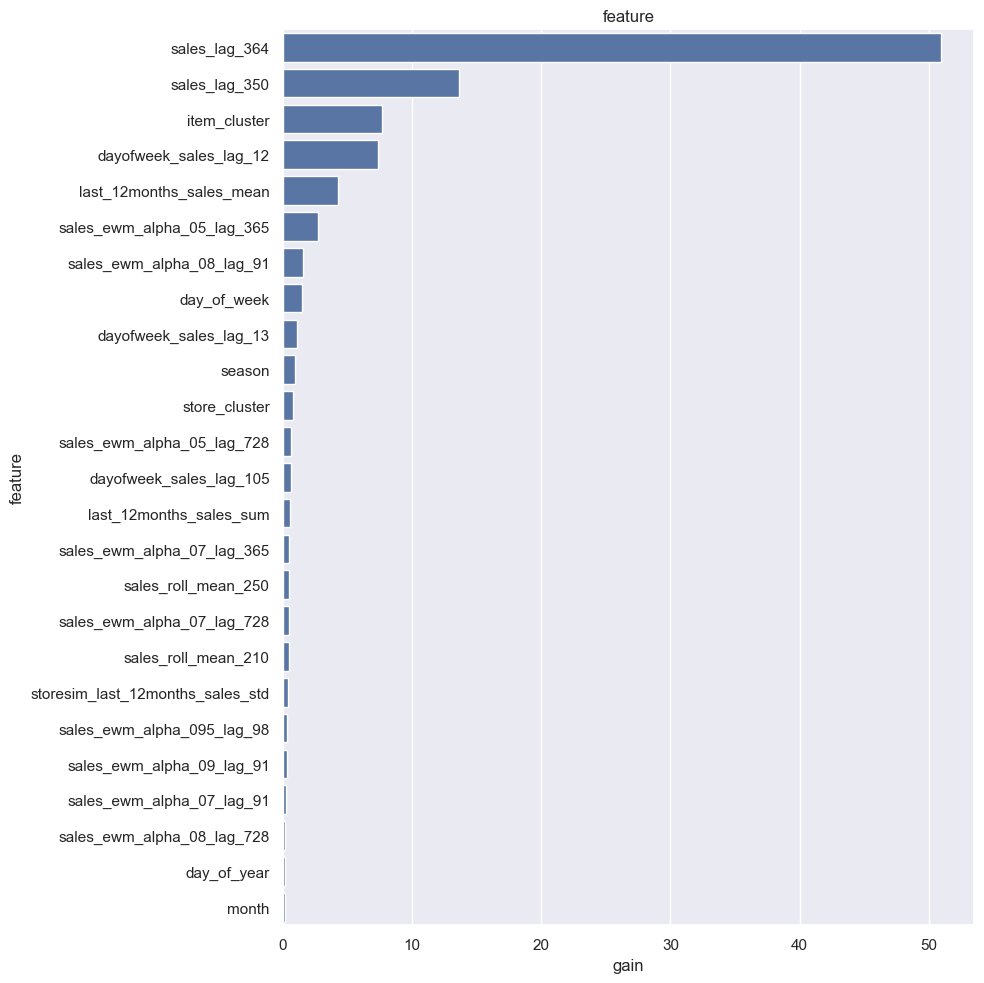

In [15]:
plot_lgb_importances(first_model, plot=True, num=30)

## SHAP Feature Importance Analysis

In this section, we use SHAP (SHapley Additive exPlanations) to explain the LightGBM model.

- SHAP provides a powerful way to understand how each feature affects the model predictions.
- We generate SHAP values for both training and validation sets.
- Then, we visualize the **average impact** of the top 30 features.

Key points:
- The longer the bar, the higher the contribution of that feature.
- SHAP values offer more detailed insights than standard feature importance because they consider feature interactions.
- In this case, features like `sales_lag_364` and `item_cluster` have the largest impact.

This plot helps us to identify the most influential features driving the sales predictions.

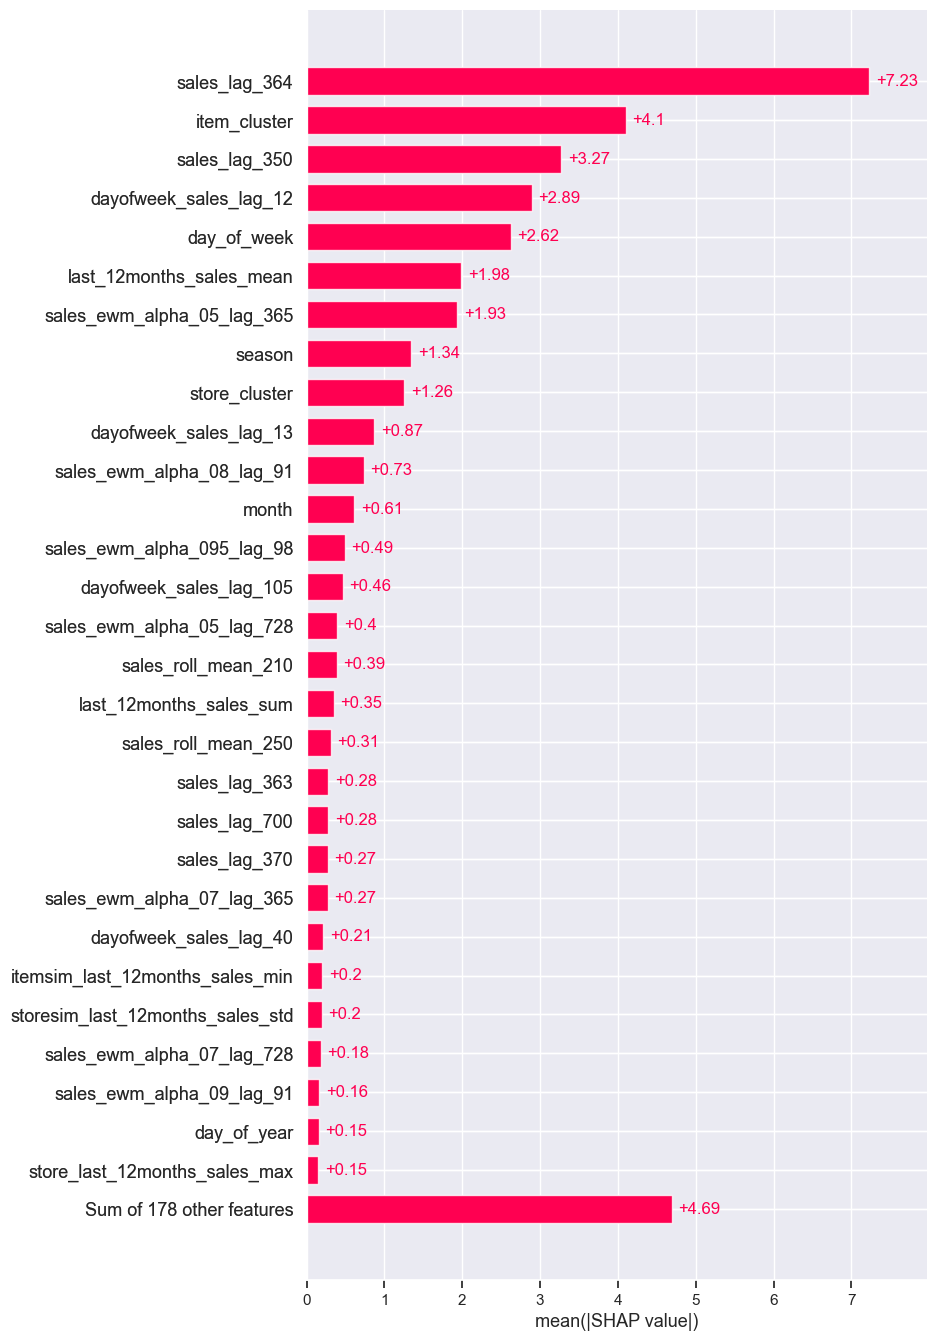

In [16]:
shap_explainer = shap.Explainer(first_model)
shap_values_train_set = shap_explainer(X_train)
shap_values_val_set = shap_explainer(X_val)
shap.plots.bar(shap_values_train_set, max_display=30)

## Error Analysis

In this section, we analyze the model errors in detail.

We first create a DataFrame containing:
- The **date** of the record.
- The **store** and **item** identifiers.
- The **actual sales** values from the validation set.
- The **predicted sales** values from the model.
- The **absolute error** (difference between actual and predicted sales).

Then, we sort the errors in descending order to inspect the largest mistakes.

### Largest Errors (Top 20)
Here we check the top 20 records with the highest absolute errors.  
This helps us identify problematic dates, stores, or items where the model performed poorly.

---

Next, we summarize the **actual sales**, **predicted sales**, and **absolute error** with descriptive statistics at several percentiles (70%, 80%, 90%, 95%, and 99%).

| Metric | Insight |
|--------|---------|
| **Mean Error:** ~6 | Model makes ~6 units of error on average. |
| **Max Error:** ~39 | In rare cases, errors can be quite high. |
| **70-90 Percentiles:** Moderate errors are common, but extreme errors are rare. |

This error analysis provides a clear view of the model’s strengths and weaknesses.

In [17]:
error = pd.DataFrame({
    "date":val.date,
    "store":X_val.store,
    "item":X_val.item,
    "actual":Y_val,
    "pred":first_model.predict(X_val)
}).reset_index(drop = True)

error["error"] = np.abs(error.actual-error.pred)

error.sort_values("error", ascending=False).head(20)

date  store  item  actual        pred      error
20687 2017-11-11      9    38     146  106.706244  39.293756
9049  2017-10-19      9    33     117   77.936250  39.063750
45421 2017-12-30      3    24     108   69.346359  38.653641
21293 2017-11-12      3    11     139  101.552880  37.447120
7240  2017-10-15      8    18     110  147.022998  37.022998
28425 2017-11-26      9    22     151  114.548868  36.451132
24731 2017-11-19      9    25     149  112.554814  36.445186
27797 2017-11-25      1    28     142  105.867611  36.132389
16874 2017-11-03      3    24     128   93.237509  34.762491
30377 2017-11-30      3    13     136  101.243031  34.756969
15455 2017-10-31      3    38      62   96.604155  34.604155
21270 2017-11-12      2    22     113  147.551813  34.551813
30000 2017-11-30      9    36     126   91.908358  34.091642
4114  2017-10-09      3    28     118   84.425476  33.574524
20128 2017-11-10     10    15     154  120.464044  33.535956
28255 2017-11-26      8     6     135  101.613645  33.386355
28950 2017-11-27      3    45     118   84.669539  33.330461
27811 2017-11-25      4    15      92  125.185744  33.185744
24980 2017-11-19      4    25      87  120.155656  33.155656
14997 2017-10-30      4    18      57   90.021122  33.021122

In [18]:
error[["actual", "pred", "error"]].describe([0.7, 0.8, 0.9, 0.95, 0.99]).T

count       mean        std       min        50%        70%  \
actual  46000.0  54.677543  28.485947  3.000000  50.000000  68.000000   
pred    46000.0  55.088427  27.447896  9.699175  51.024065  68.125394   
error   46000.0   6.010774   4.955876  0.000141   4.812738   7.590603   

              80%        90%         95%         99%         max  
actual  79.000000  95.000000  109.000000  132.000000  174.000000  
pred    78.739337  93.867674  106.610561  127.407372  159.062929  
error    9.582411  12.784739   15.724743   22.127114   39.293756

## Sales Trend Comparison for Store 1 - (A)

### 1. Individual Item Sales Trends (Actual vs Predicted)

In this part, we analyze the sales patterns of **Store 1** by plotting actual and predicted sales separately for each item.

- Each subplot shows one item's sales over time.
- Solid lines represent actual sales, dashed lines represent model predictions.
- We use separate plots for all 50 items to observe the detailed behavior.

This approach helps to visually inspect prediction performance **item by item**.  
However, it can be overwhelming due to the large number of items.


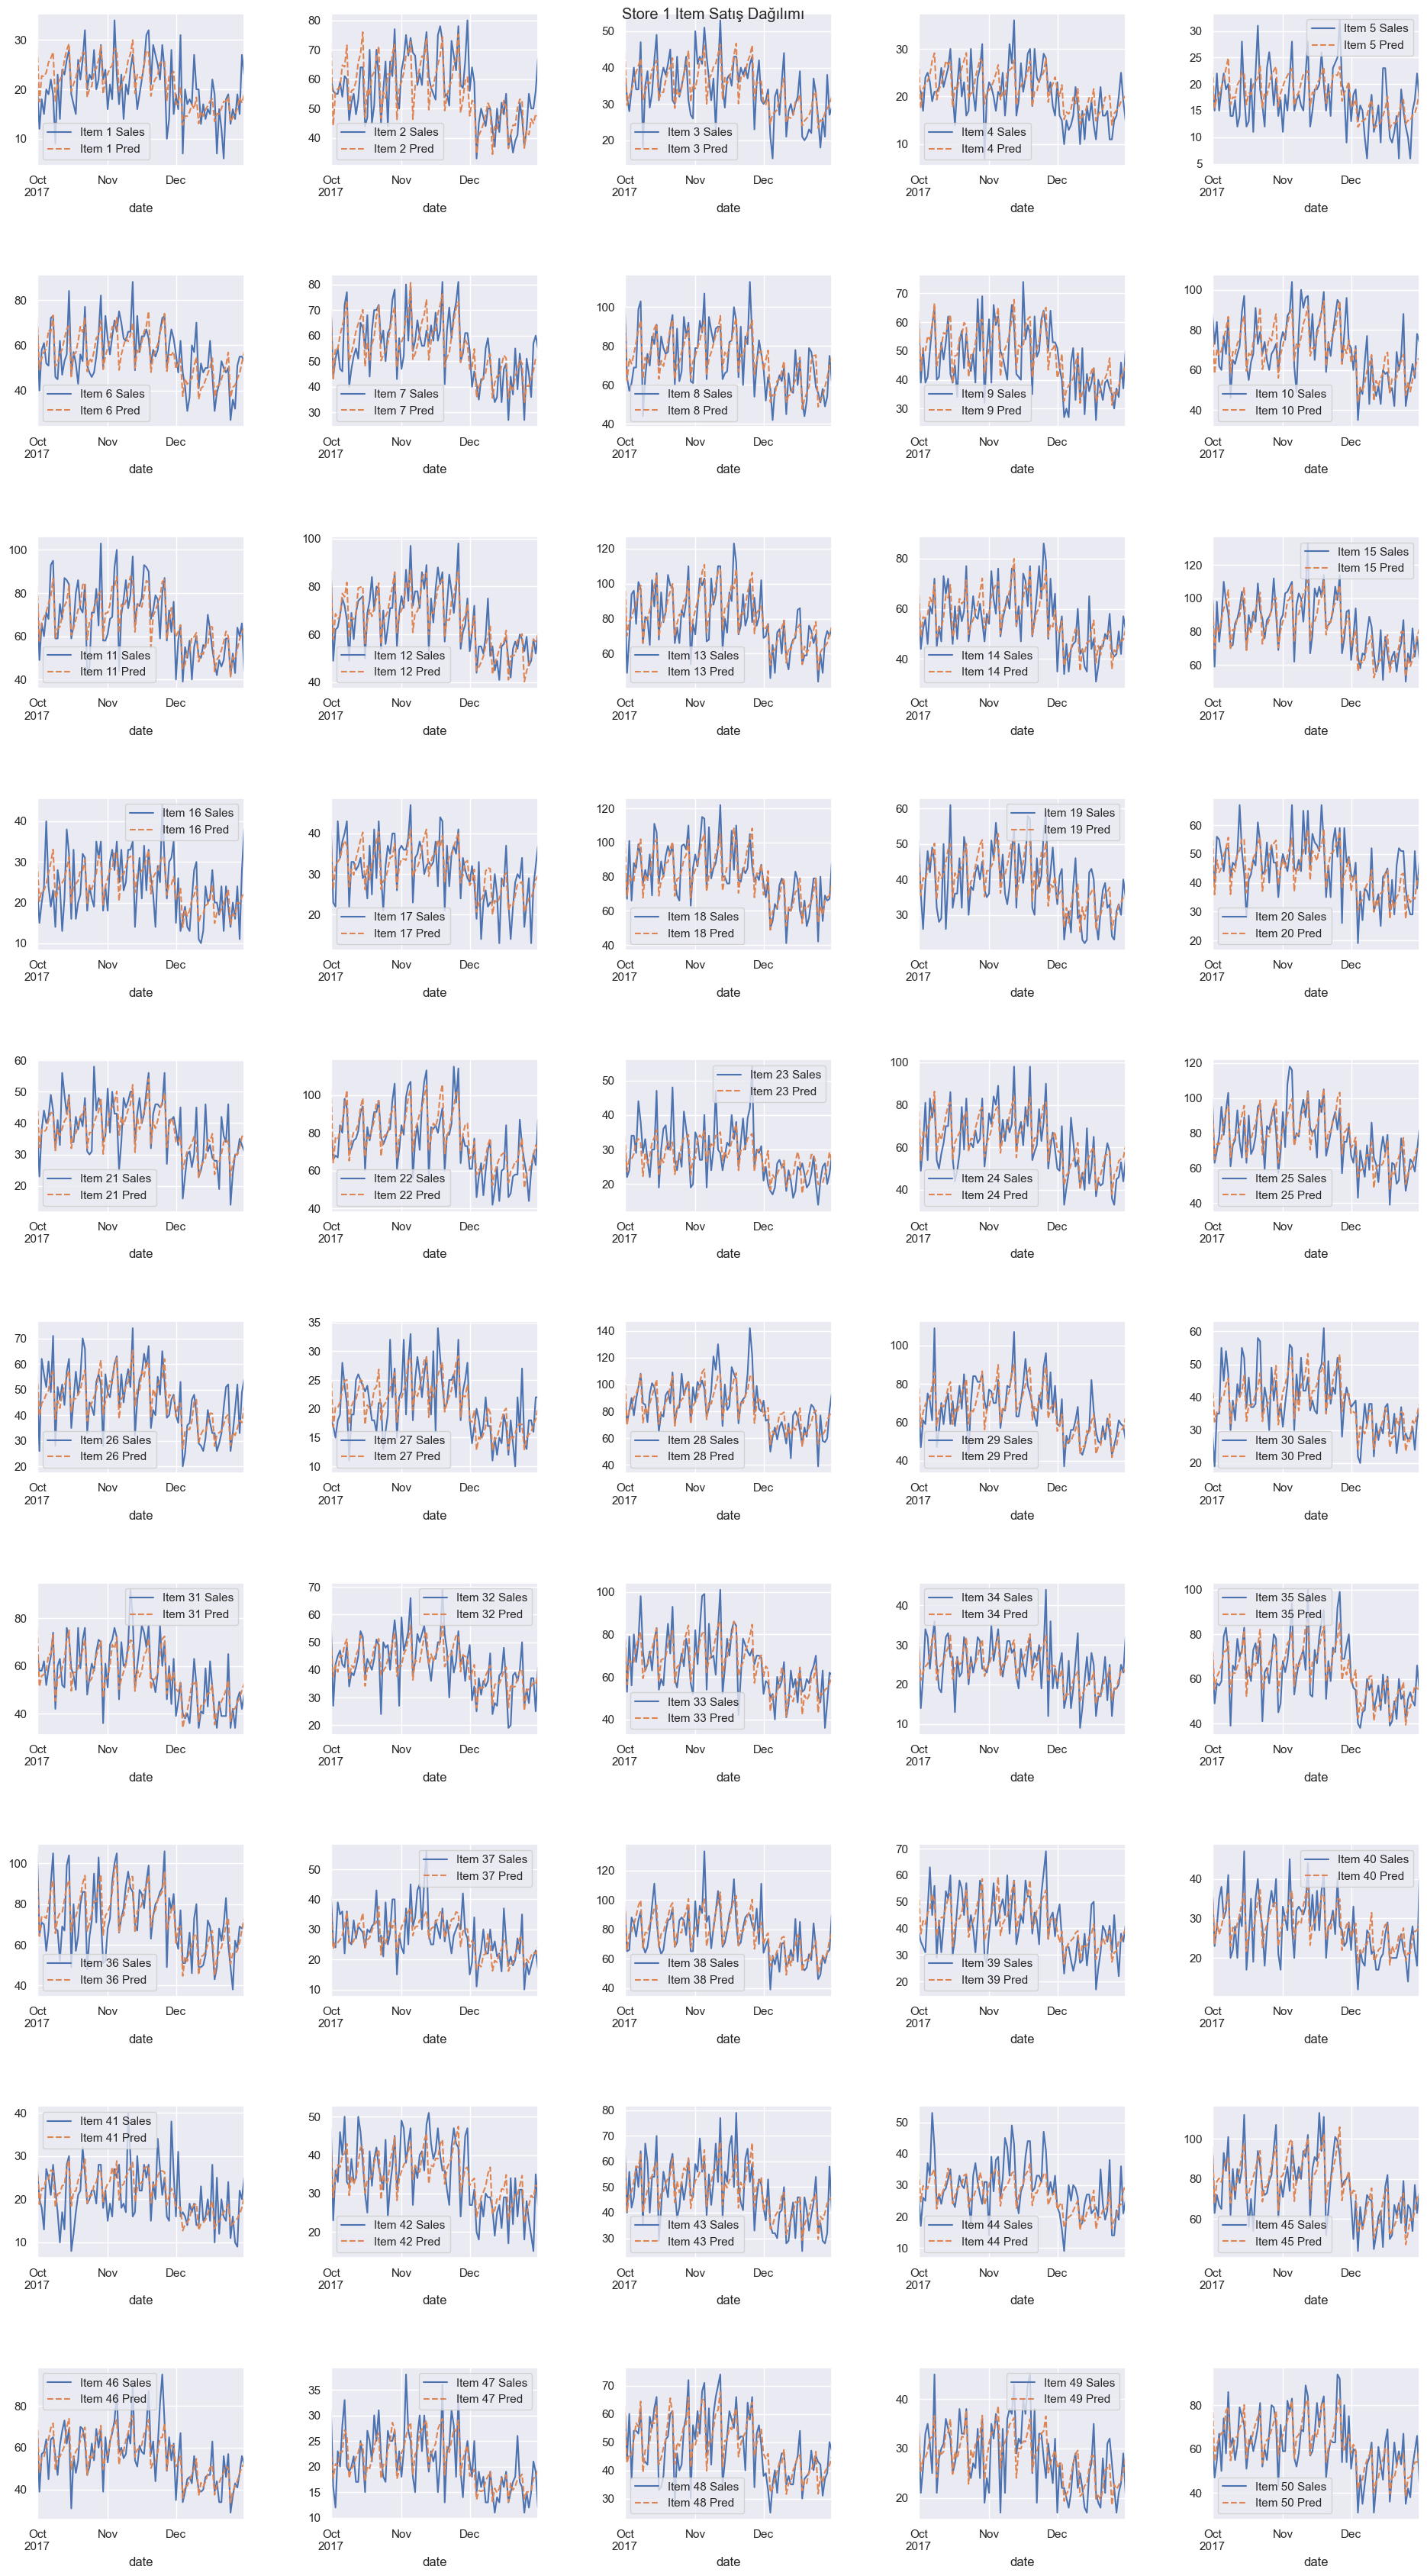

In [19]:
# Store 1 Actual - Pred
sub = error[error.store == 1].set_index("date")
fig, axes = plt.subplots(10, 5, figsize=(20, 35))
for i in range(1,51):
    if i < 6:
        sub[sub.item == i].actual.plot(ax=axes[0, i-1], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[0, i - 1], legend=True, label="Item " + str(i) + " Pred", linestyle = "dashed")
    if i >= 6 and i<11:
        sub[sub.item == i].actual.plot(ax=axes[1, i - 6], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[1, i - 6], legend=True, label="Item " + str(i) + " Pred",  linestyle="dashed")
    if i >= 11 and i<16:
        sub[sub.item == i].actual.plot(ax=axes[2, i - 11], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[2, i - 11], legend=True, label="Item " + str(i) + " Pred", linestyle="dashed")
    if i >= 16 and i<21:
        sub[sub.item == i].actual.plot(ax=axes[3, i - 16], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[3, i - 16], legend=True, label="Item " + str(i) + " Pred", linestyle="dashed")
    if i >= 21 and i<26:
        sub[sub.item == i].actual.plot(ax=axes[4, i - 21], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[4, i - 21], legend=True, label="Item " + str(i) + " Pred", linestyle="dashed")
    if i >= 26 and i<31:
        sub[sub.item == i].actual.plot(ax=axes[5, i - 26], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[5, i - 26], legend=True, label="Item " + str(i) + " Pred", linestyle="dashed")
    if i >= 31 and i<36:
        sub[sub.item == i].actual.plot(ax=axes[6, i - 31], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[6, i - 31], legend=True, label="Item " + str(i) + " Pred", linestyle="dashed")
    if i >= 36 and i<41:
        sub[sub.item == i].actual.plot(ax=axes[7, i - 36], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[7, i - 36], legend=True, label="Item " + str(i) + " Pred", linestyle="dashed")
    if i >= 41 and i<46:
        sub[sub.item == i].actual.plot(ax=axes[8, i - 41], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[8, i - 41], legend=True, label="Item " + str(i) + " Pred",linestyle="dashed")
    if i >= 46 and i<51:
        sub[sub.item == i].actual.plot(ax=axes[9, i - 46], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[9, i - 46], legend=True, label="Item " + str(i) + " Pred",linestyle="dashed")
plt.tight_layout(pad=4.5)
plt.suptitle("Store 1 Item Satış Dağılımı");
plt.show()

## Sales Trend Comparison for Store 1 - (B)

### 2. Aggregated Sales Trend with Z-score Normalization

To simplify the comparison, we calculate the **Z-score** (standardization) of actual and predicted sales for each item.

- Z-score standardization makes the series comparable by removing scale differences.
- Then, we compute the **average Z-score** across all items.
- This gives us an overall sales trend for the store.

In the final plot:
- **Blue Line:** Average of standardized actual sales across items.
- **Red Dashed Line:** Average of standardized predicted sales across items.

This aggregated approach offers a **clearer and more concise** view of the overall model performance on Store 1.

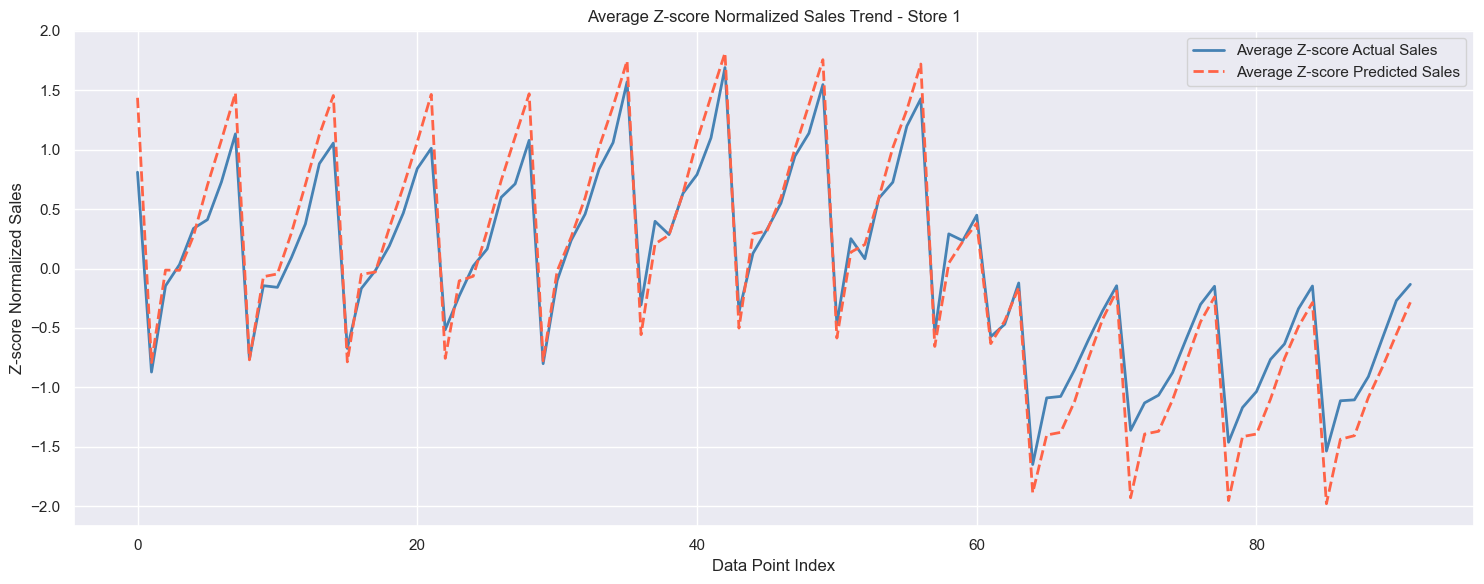

In [20]:
sub = error[error.store == 1].set_index("date")

zscore_actuals = []
zscore_preds = []

for i in range(1, 51):
    actual_series = sub[sub.item == i].actual.reset_index(drop=True)
    pred_series = sub[sub.item == i].pred.reset_index(drop=True)

    zscore_actual = zscore(actual_series)
    zscore_pred = zscore(pred_series)

    zscore_actuals.append(pd.Series(zscore_actual))
    zscore_preds.append(pd.Series(zscore_pred))

avg_zscore_actual = pd.concat(zscore_actuals, axis=1).mean(axis=1)
avg_zscore_pred = pd.concat(zscore_preds, axis=1).mean(axis=1)

plt.figure(figsize=(15, 6))
plt.plot(avg_zscore_actual, label='Average Z-score Actual Sales', linewidth=2, color='steelblue')
plt.plot(avg_zscore_pred, label='Average Z-score Predicted Sales', linewidth=2, color='tomato', linestyle='--')
plt.title("Average Z-score Normalized Sales Trend - Store 1")
plt.xlabel("Data Point Index")
plt.ylabel("Z-score Normalized Sales")
plt.legend()
plt.tight_layout()
plt.show()

## Error Analysis: Visual Insights

This section presents a comprehensive error analysis through several diagnostic plots.

- **Error Histogram:**  
  Shows the distribution of prediction errors. The errors are centered around zero, resembling a bell-shaped curve, suggesting no severe bias in predictions.

- **Absolute Error Histogram:**  
  Displays the magnitude of prediction errors. Most errors are concentrated in the lower range, indicating generally small deviations between actual and predicted values.

- **Standardized Residuals vs. Fitted Values:**  
  This scatter plot helps identify potential patterns or heteroscedasticity in residuals. The spread appears fairly consistent across the fitted values, which is a positive sign.

- **Standardized Residuals² vs. Fitted Values:**  
  Another view to check variance patterns. No clear funnel shape is visible, suggesting stable variance throughout the predictions.

- **Actual Histogram:**  
  The sales values exhibit a right-skewed distribution, meaning lower sales values are more frequent, with a long tail toward higher sales.

- **Predicted Histogram:**  
  The distribution of predicted sales closely matches the actual sales histogram, indicating that the model captures the general distribution well.

- **Actual vs. Predicted Scatter Plot:**  
  Shows a strong linear relationship between actual and predicted values, implying good predictive performance.

- **QQ Plot:**  
  Assesses the normality of predictions. The plot shows slight deviations from the theoretical normal distribution, especially at the tails, but the overall pattern stays within acceptable limits.

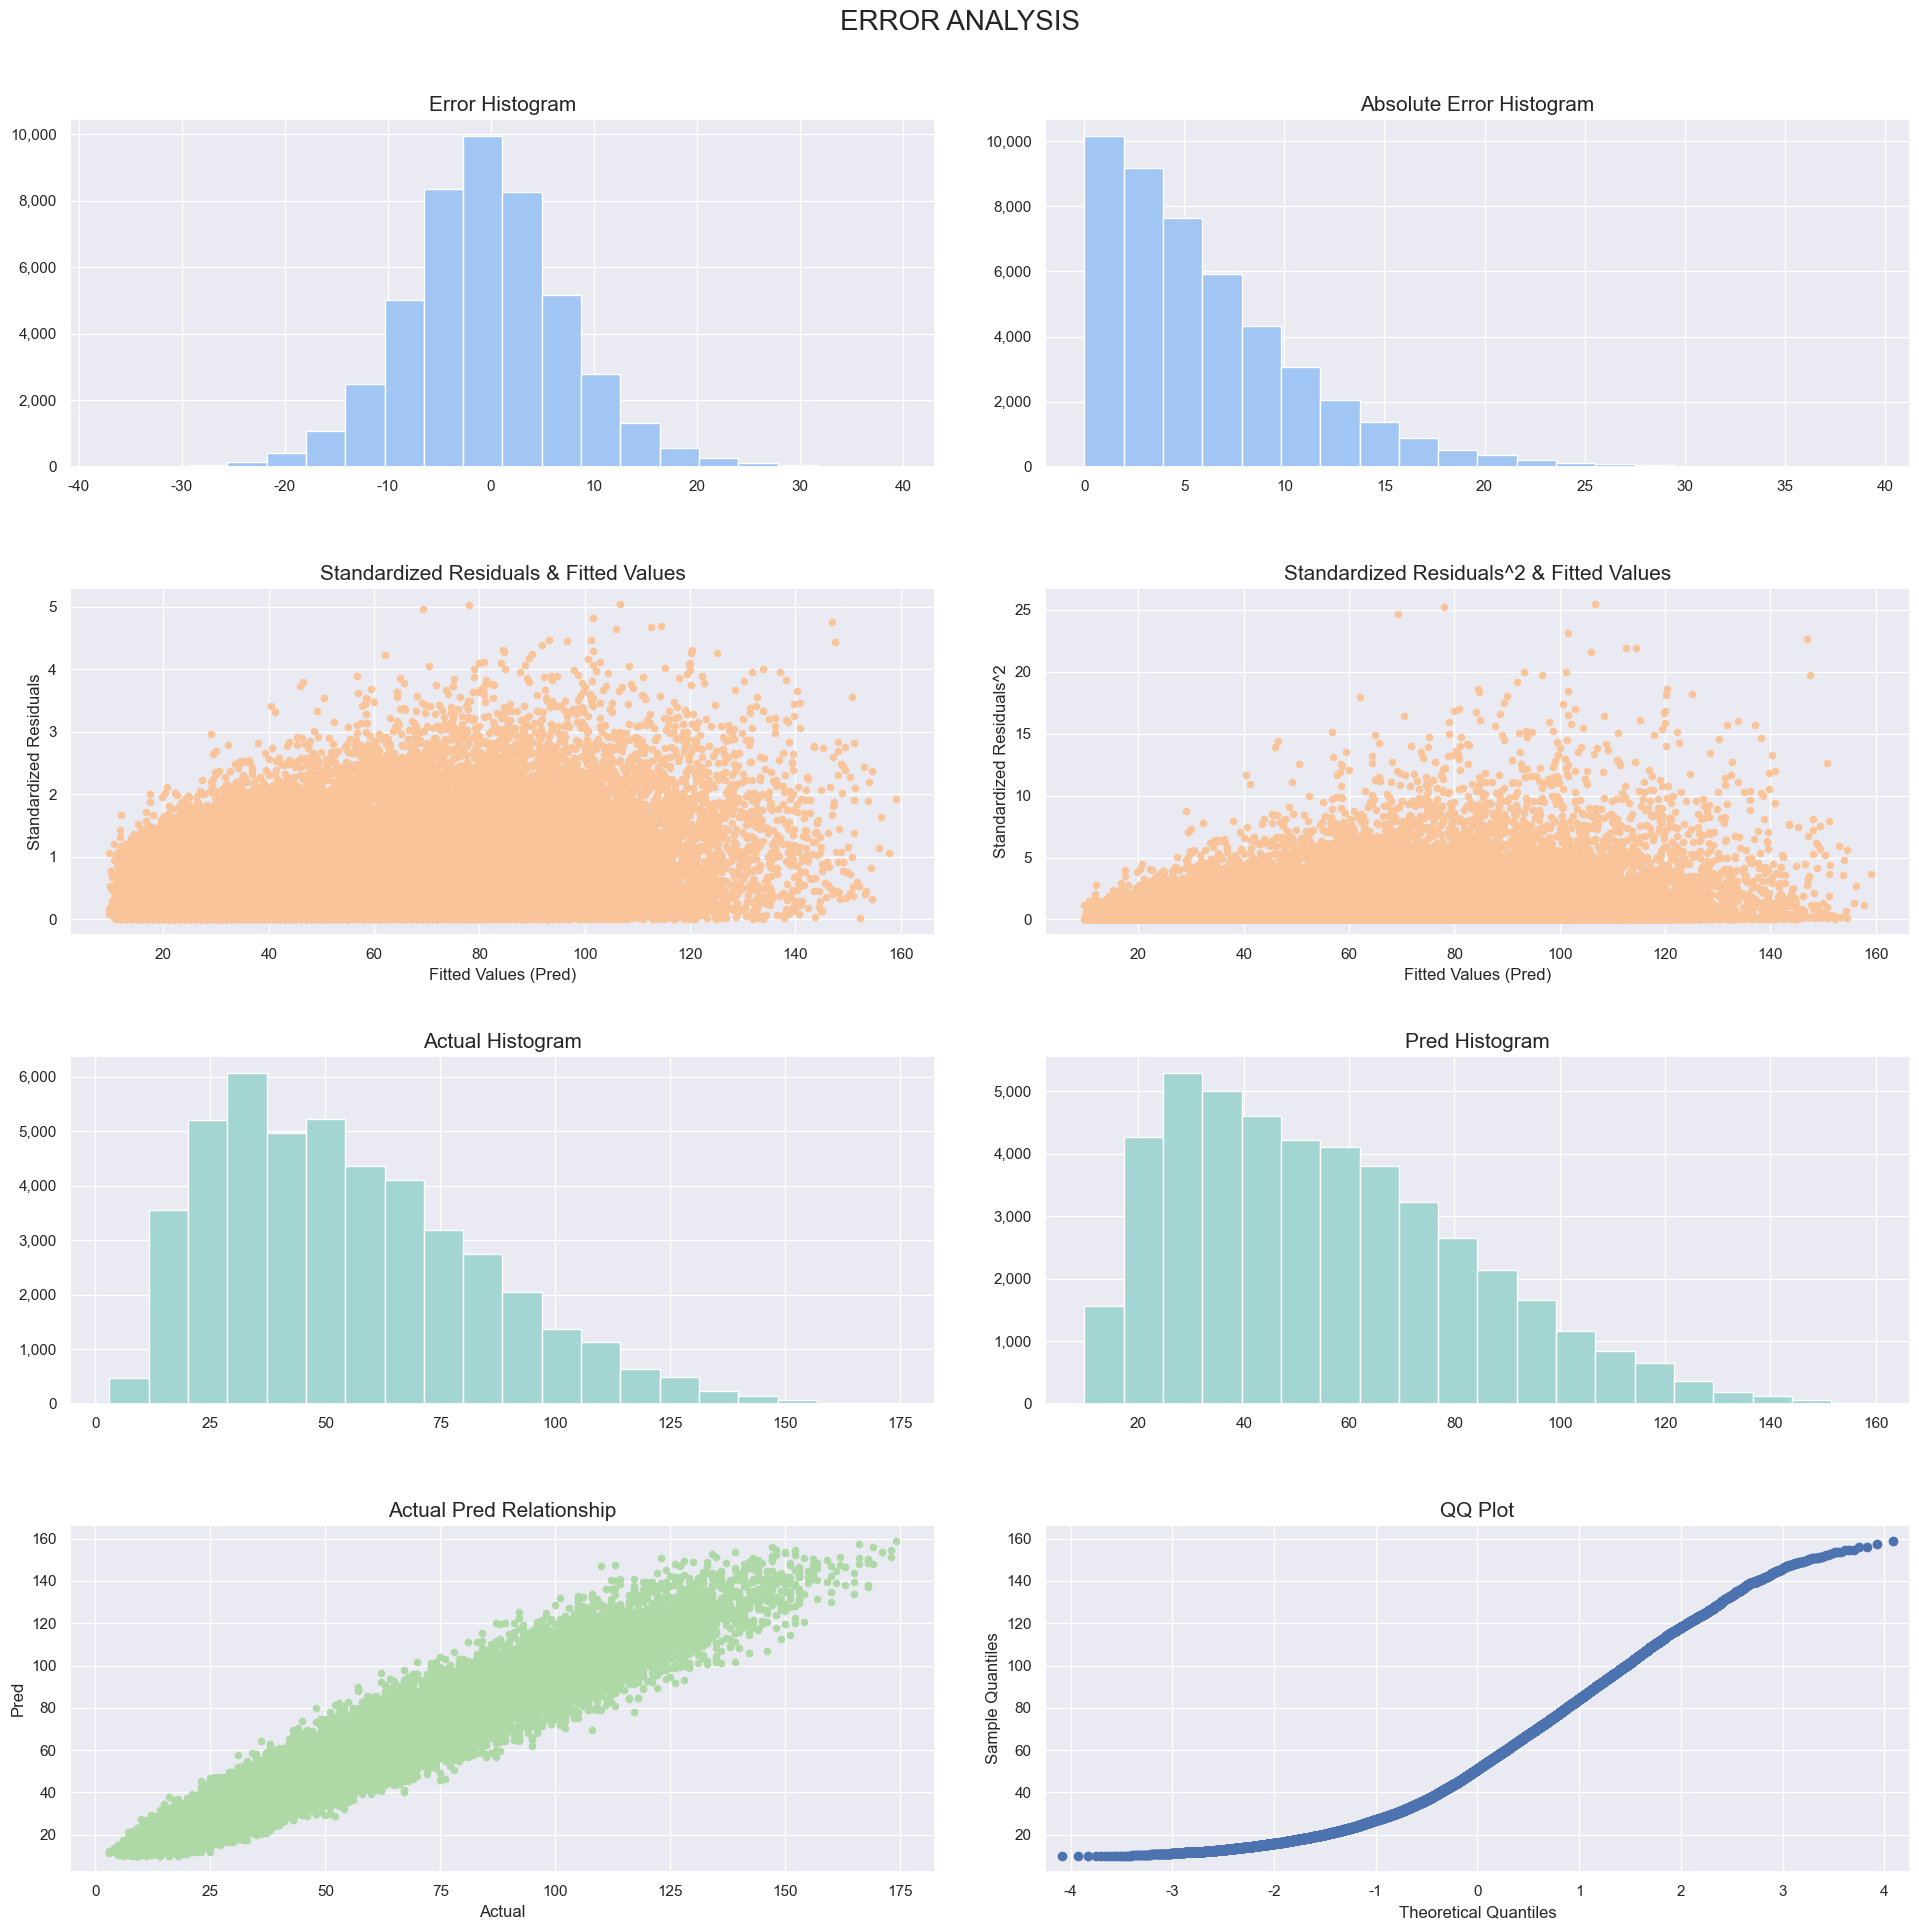

In [21]:
fig, axes = plt.subplots(4, 2, figsize=(20, 20))

for axi in axes.flat:
    axi.ticklabel_format(style="sci", axis="y", scilimits=(0, 10))
    axi.ticklabel_format(style="sci", axis="x", scilimits=(0, 10))
    axi.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    axi.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

(error.actual - error.pred).hist(ax=axes[0, 0], color="#A2C6F3", bins=20)
error.error.hist(ax=axes[0, 1], color="#A2C6F3", bins=20)

sr = error.copy()
sr["StandardizedR"] = sr.error / (sr.actual - sr.pred).std()
sr["StandardizedR2"] = (sr["StandardizedR"]) ** 2

sr.plot.scatter(x="pred", y="StandardizedR", color="#F9C49A", ax=axes[1, 0])
sr.plot.scatter(x="pred", y="StandardizedR2", color="#F9C49A", ax=axes[1, 1])

error.actual.hist(ax=axes[2, 0], color="#A3D5D3", bins=20)
error.pred.hist(ax=axes[2, 1], color="#A3D5D3", bins=20)
error.plot.scatter(x="actual", y="pred", color="#AED9A7", ax=axes[3, 0])

sm.qqplot(sr.pred, ax=axes[3, 1], color="#C0C0C0")

plt.suptitle("ERROR ANALYSIS", fontsize=20)

axes[0, 0].set_title("Error Histogram", fontsize=15)
axes[0, 1].set_title("Absolute Error Histogram", fontsize=15)
axes[1, 0].set_title("Standardized Residuals & Fitted Values", fontsize=15)
axes[1, 1].set_title("Standardized Residuals^2 & Fitted Values", fontsize=15)
axes[2, 0].set_title("Actual Histogram", fontsize=15)
axes[2, 1].set_title("Pred Histogram", fontsize=15)
axes[3, 0].set_title("Actual Pred Relationship", fontsize=15)
axes[3, 1].set_title("QQ Plot", fontsize=15)

axes[1, 0].set_xlabel("Fitted Values (Pred)", fontsize=12)
axes[1, 1].set_xlabel("Fitted Values (Pred)", fontsize=12)
axes[3, 0].set_xlabel("Actual", fontsize=12)
axes[1, 0].set_ylabel("Standardized Residuals", fontsize=12)
axes[1, 1].set_ylabel("Standardized Residuals^2", fontsize=12)
axes[3, 0].set_ylabel("Pred", fontsize=12)

fig.tight_layout(pad=3.0)
plt.show()

## Feature Selection & Model Simplification

In this step, we simplify the model by selecting only the most important features.

- We used the **feature importance (gain)** from the first model.
- Only the features with more than **1.5% importance** were kept.
- This resulted in **66 independent variables** (down from 207).

Then, we trained a new LightGBM model using these selected features.

### Model Results:
- **Train SMAPE:** ~13.01
- **Validation SMAPE:** ~12.64

### Key Observations:
- The model performance remained almost the same as the full-feature model.
- The model is now simpler, faster, and more interpretable.
- This approach can help improve model stability and reduce overfitting risk.

Overall, this feature reduction provided a **lighter model** with **no loss in accuracy**.

In [22]:
cols = feature_imp_df[feature_imp_df.gain > 0.015].feature.tolist()
print("Independent Variables:", len(cols))

second_model = lgb.LGBMRegressor(random_state=384).fit(
    X_train[cols], Y_train, 
    eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

print("TRAIN SMAPE:", smape(Y_train, second_model.predict(X_train[cols])))
print("VALID SMAPE:", smape(Y_val, second_model.predict(X_val[cols])))

Independent Variables: 66
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13080
[LightGBM] [Info] Number of data points in the train set: 867000, number of used features: 66
[LightGBM] [Info] Start training from score 52.121505
TRAIN SMAPE: 13.010959663561707
VALID SMAPE: 12.64303832110357


## Final Model Training and Full Data Fit

In this step, we finalize the model using all available training data.

### Steps:
1. **Hyperparameter Tuning:**  
   - The best iteration from the tuned model was found using early stopping.
   - Best iteration: **716 rounds**.

2. **Full Data Training:**  
   - We retrained the model using the entire dataset up to **January 1, 2018**.
   - The model was set to use exactly **716 iterations** (best value from tuning).

3. **Final Model Evaluation:**  
   - SMAPE was calculated on the entire training data.
   - This provides an indicator of the model's fit before predictions.

### Why This Step?
- Using all data improves the model’s ability to generalize.
- Fixing the number of iterations avoids overfitting during full-data training.

This step completes the **final production-ready model**.

In [23]:
model_tuned2 = lgb.LGBMRegressor(
    num_leaves=31, 
    n_estimators=15000, 
    max_depth=20, 
    random_state=384
)

model_tuned2.fit(
    X_train[cols], Y_train,
    eval_metric=lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)],
    eval_set=[(X_train[cols], Y_train), (X_val[cols], Y_val)],
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=100)]
)

print("Best Iteration:", model_tuned2.booster_.best_iteration)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13080
[LightGBM] [Info] Number of data points in the train set: 867000, number of used features: 66
[LightGBM] [Info] Start training from score 52.121505
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 56.3059	valid_0's SMAPE: 13.011	valid_1's l2: 60.6554	valid_1's SMAPE: 12.643
[200]	valid_0's l2: 54.4045	valid_0's SMAPE: 12.8283	valid_1's l2: 59.2829	valid_1's SMAPE: 12.5226
[300]	valid_0's l2: 53.4103	valid_0's SMAPE: 12.7407	valid_1's l2: 58.8233	valid_1's SMAPE: 12.4743
[400]	valid_0's l2: 52.6962	valid_0's SMAPE: 12.6855	valid_1's l2: 58.6906	valid_1's SMAPE: 12.4569
[500]	valid_0's l2: 52.0972	valid_0's SMAPE: 12.6416	valid_1's l2: 58.6525	valid_1's SMAPE: 12.4451
[600]	valid_0's l2: 51.5672	val

In [24]:
df.sort_values(["store", "item", "date"], inplace=True)

train_final = df[df["date"] < "2018-01-01"]
test_final = df[df["date"] >= "2018-01-01"]

X_train_final = train_final[cols]
Y_train_final = train_final["sales"]
X_test_final = test_final[cols]

final_model = lgb.LGBMRegressor(**model_tuned2.get_params())
final_model.set_params(n_estimators=model_tuned2.booster_.best_iteration)

final_model.fit(
    X_train_final,
    Y_train_final,
    eval_metric=lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13124
[LightGBM] [Info] Number of data points in the train set: 913000, number of used features: 66
[LightGBM] [Info] Start training from score 52.250287


LGBMRegressor(max_depth=20, n_estimators=716, random_state=384)

In [25]:
Y_train_pred = final_model.predict(X_train_final)
print("Final Model Train SMAPE:", smape(Y_train_pred, Y_train_final))

Final Model Train SMAPE: 12.553172479356368


In [26]:
# last_year = df["date"].max() - pd.DateOffset(years=1)
# test_last_year = df[(df["date"] >= last_year) & (df["date"] <= df["date"].max())].copy()

# X_test_last_year = test_last_year[cols]
# test_last_year["prediction"] = final_model.predict(X_test_last_year)

# best_item = test_last_year.groupby("item")["error"].mean().idxmin() if "error" in test_last_year.columns else \
#             test_last_year.groupby("item")["prediction"].mean().idxmax()

# print("Best Item for Plotting:", best_item)

# best_item_data = test_last_year[test_last_year["item"] == best_item]

# plt.figure(figsize=(12, 6))
# plt.plot(best_item_data["date"], best_item_data["sales"], label="Actual Sales", linewidth=2, color="steelblue")
# plt.plot(best_item_data["date"], best_item_data["prediction"], label="Predicted Sales", linewidth=2, color="tomato", linestyle="--")
# plt.title(f"Sales Forecast for Item {best_item} (Last 1 Year)")
# plt.xlabel("Date")
# plt.ylabel("Sales")
# plt.legend()
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# Sales Forecast Visualization for a Random Item

In this plot, we visualize the model’s sales predictions for a specific item in a selected store over the last available year of data.

- The **blue line** represents the actual sales.
- The **red dashed line** represents the predicted sales.

This allows us to:
- Compare the prediction accuracy for a specific product.
- Observe seasonal patterns or anomalies.
- Understand how well the model captures sales trends for that item-store combination.

You can easily change the `selected_item` and `selected_store` variables to analyze different products or stores.

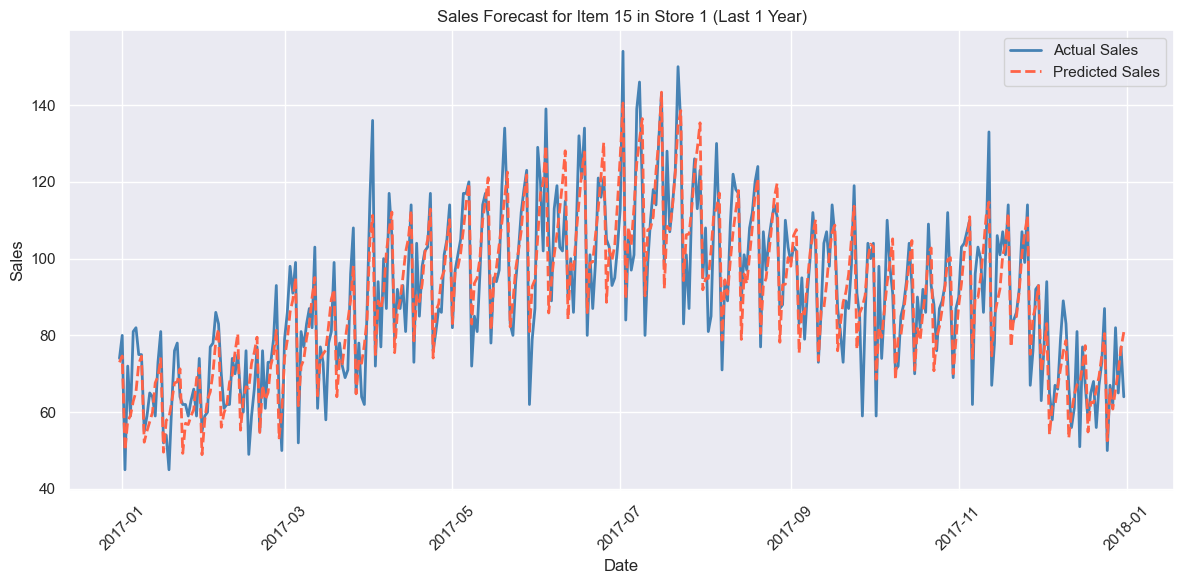

In [27]:
selected_item = 15
selected_store = 1  # İstediğin mağaza

last_year_start = df["date"].max() - pd.DateOffset(years=1)
test_last_year = df[(df["date"] >= last_year_start) & (df["date"] <= df["date"].max())].copy()

X_test_last_year = test_last_year[cols]
test_last_year["prediction"] = final_model.predict(X_test_last_year)

item_data = test_last_year[(test_last_year["item"] == selected_item) & 
                           (test_last_year["store"] == selected_store)]

plt.figure(figsize=(12, 6))
plt.plot(item_data["date"], item_data["sales"], label="Actual Sales", linewidth=2, color="steelblue")
plt.plot(item_data["date"], item_data["prediction"], label="Predicted Sales", linewidth=2, color="tomato", linestyle="--")
plt.title(f"Sales Forecast for Item {selected_item} in Store {selected_store} (Last 1 Year)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()